Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['save', 'load', 'qr']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


[ 222    0    0    0    9    0    0    0    0    0    0   33   25    0
 -129    0    0   77    0    0    0    0    0    0    0    0    0   12
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0   82    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
1111001101000111101011101100101110110001001100111110101111110010111001111011011111000001110010111001......
b'\x00\xf3G\xae\xcb\xb13\xeb\xf2\xe7\xb7\xc1\xcb\x9f\xc1\xcb\xb1+\xaf\xaf'......
Image original size:    0.750 MB
Compression image size: 0.026 MB
Compression ratio:      28.76 : 1
1101001101110001111100011100100010110111100011111000110111111101100011000110111111101100011000111001......
b'\x07\xd3q\xf1\xc8\xb7\x8f\x8d\xfd\x8co\xecc\x91)x\xf8\xe5N.'......
Image original size:    0.750 MB
Compression image size: 0.020 MB
Compression ratio:      37.45 : 1
[77]
[0 1]
[0 0 0]
[0 0 0 0]
[0 0 0 0 0]
[0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 

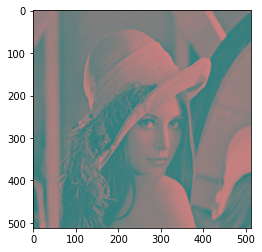

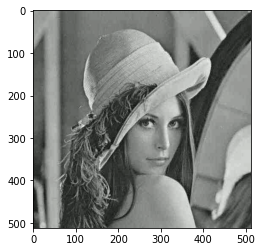

In [ ]:
%pylab inline
import scipy.misc
import cv2
img1 = cv2.imread('/content/lena1.pgm')
img = img1
w=8 #modify it if you want, maximal 8 due to default quantization table is 8*8
w=max(2,min(8,w))
h=w
xLen = img.shape[1]//w
yLen = img.shape[0]//h
runBits=1 #modify it if you want
bitBits=3  #modify it if you want
rbBits=runBits+bitBits ##(run,bitSize of coefficient)
useYCbCr=True #modify it if you want
useHuffman=True #modify it if you want
quantizationRatio=1 #modify it if you want, quantization table=default quantization table * quantizationRatio

from skimage.color import rgb2ycbcr,ycbcr2rgb
def myYcbcr2rgb(ycbcr):
  return (ycbcr2rgb(ycbcr).clip(0,1)*255).astype(uint8)
originalImg=copy(img)
ycbcr=rgb2ycbcr(img)
rgb=myYcbcr2rgb(ycbcr)
imshow(ycbcr.astype(uint8))
figure()
imshow(rgb)
if (useYCbCr):
  img=ycbcr
allclose(rgb,originalImg,atol=1)

def toBlocks(img):
  blocks = zeros((yLen,xLen,h,w,3),dtype=int16)
  for y in range(yLen):
    for x in range(xLen):
      blocks[y][x]=img[y*h:(y+1)*h,x*w:(x+1)*w]
  return array(blocks)
blocks = toBlocks(img)

from scipy.fftpack import dct,idct
def dctOrDedctAllBlocks(blocks,type="dct"):
  f=dct if type=="dct" else idct
  dedctBlocks = zeros((yLen,xLen,h,w,3))
  for y in range(yLen):
    for x in range(xLen):
      d = zeros((h,w,3))
      for i in range(3):
        block=blocks[y][x][:,:,i]
        d[:,:,i]=f(f(block.T, norm = 'ortho').T, norm = 'ortho')
        if (type!="dct"):
          d=d.round().astype(int16)
      dedctBlocks[y][x]=d
  return dedctBlocks
dctBlocks=dctOrDedctAllBlocks(blocks,"dct")

def blocks2img(blocks):
  W=xLen*w
  H=yLen*h
  img = zeros((H,W,3))
  for y in range(yLen):
    for x in range(xLen):
      img[y*h:y*h+h,x*w:x*w+w]=blocks[y][x]
  return img
newImg=blocks2img(dctBlocks)


#quantization table
QY=array([[16,11,10,16,24,40,51,61],
     [12,12,14,19,26,58,60,55],
     [14,13,16,24,40,57,69,56],
     [14,17,22,29,51,87,80,62],
     [18,22,37,56,68,109,103,77],
     [24,35,55,64,81,104,113,92],
     [49,64,78,87,103,121,120,101],
     [72,92,95,98,112,100,103,99]])
QC=array([[17,18,24,47,99,99,99,99],
     [18,21,26,66,99,99,99,99],
     [24,26,56,99,99,99,99,99],
     [47,66,99,99,99,99,99,99],
     [99,99,99,99,99,99,99,99],
     [99,99,99,99,99,99,99,99],
     [99,99,99,99,99,99,99,99],
     [99,99,99,99,99,99,99,99]])
QY=QY[:w,:h]
QC=QC[:w,:h]
qDctBlocks=copy(dctBlocks)
Q3 = moveaxis(array([QY]+[QC]+[QC]),0,2)*quantizationRatio if useYCbCr else dstack([QY*quantizationRatio]*3)#all r-g-b/Y-Cb-Cr 3 channels need to be quantized
Q3=Q3*((11-w)/3)
qDctBlocks=(qDctBlocks/Q3).round().astype('int16') 

qDctImg=blocks2img(qDctBlocks).astype('int16')
Qrandom=arange(200,200+w*h).reshape(w,h)
qRandDctBlocks=copy(dctBlocks)
Qr3 = dstack([Qrandom]*3)
qRandDctBlocks/=Qr3
qRandDctBlocks=qRandDctBlocks.round().astype('int16')
dedctBlocks=dctOrDedctAllBlocks(dctBlocks,"idct")
dedctBlocks=dctOrDedctAllBlocks(qDctBlocks*Q3,"idct")
dedctBlocks=dctOrDedctAllBlocks(qRandDctBlocks*Qr3,"idct")


def zigZag(block):
  lines=[[] for i in range(h+w-1)] 
  for y in range(h): 
    for x in range(w): 
      i=y+x 
      if(i%2 ==0): 
          lines[i].insert(0,block[y][x]) 
      else:  
          lines[i].append(block[y][x]) 
  return array([coefficient for line in lines for coefficient in line])
zigZag(qDctBlocks[0][0][:,:,0])


!pip install huffman
import huffman
from collections import Counter
def huffmanCounter(zigZagArr):
  rbCount=[]
  run=0
  for AC in zigZagArr[1:]:
    if(AC!=0):
      AC=max(AC,1-2**(2**bitBits-1)) if AC<0 else min(AC,2**(2**bitBits-1)-1)
      if(run>2**runBits-1):
        runGap=2**runBits
        k=run//runGap
        for i in range(k):
          rbCount.append('1'*runBits+'0'*bitBits)
        run-=k*runGap
      run=min(run,2**runBits-1) 
      bitSize=min(int(ceil(log(abs(AC)+0.000000001)/log(2))),2**bitBits-1)
      rbCount.append(format(run<<bitBits|bitSize,'0'+str(rbBits)+'b'))
      run=0
    else:
      run+=1
  rbCount.append("0"*(rbBits))
  return Counter(rbCount)
rbCount=zeros(3,dtype=Counter)
rbCount[0]=huffmanCounter(zigZag(qDctBlocks[0][0][:,:,0]))
rbCount[1]=huffmanCounter(zigZag(qDctBlocks[0][0][:,:,1]))
rbCount[2]=huffmanCounter(zigZag(qDctBlocks[0][0][:,:,2]))
rbCount=sum(rbCount)


def runLengthReadable(zigZagArr,lastDC):
  rlc=[]
  run=0
  newDC=min(zigZagArr[0],2**(2**bitBits-1)-1)
  DC=newDC-lastDC
  bitSize=max(0,min(int(ceil(log(abs(DC)+0.000000001)/log(2))),2**bitBits-1))
  rlc.append([array(bitSize),DC])
  code=format(bitSize, '0'+str(bitBits)+'b')+"\n"
  if (bitSize>0):
    code=code[:-1]+","+(format(DC,"b") if DC>0 else ''.join([str((int(b)^1)) for b in format(abs(DC),"b")]))+"\n"
  for AC in zigZagArr[1:]:
    if(AC!=0):
      AC=max(AC,1-2**(2**bitBits-1)) if AC<0 else min(AC,2**(2**bitBits-1)-1)
      if(run>2**runBits-1):
        runGap=2**runBits
        k=run//runGap
        for i in range(k):
          code+='1'*runBits+'0'*bitBits+'\n'
          rlc.append([runGap-1,0])
        run-=k*runGap
      bitSize=min(int(ceil(log(abs(AC)+0.000000001)/log(2))),2**bitBits-1)
      #VLI encoding (next 2 lines of codes)
      code+=format(run<<bitBits|bitSize,'0'+str(rbBits)+'b')+','
      code+=(format(AC,"b") if AC>=0 else ''.join([str((int(b)^1)) for b in format(abs(AC),"b")]))+"\n"
      rs=zeros(1,dtype=object)
      rs[0]=array([run,bitSize])
      rs= append(rs,AC)
      rlc.append(rs)
      run=0
    else:
      run+=1
  rlc.append([0,0])
  code+="0"*(rbBits)#end
  return array(rlc),code,newDC
b=zeros(64,dtype=int16)
b[0]=222
b[4]=9
b[11]=33
b[12]=25
b[14]=-129
b[17]=77
b[27]=12
b[47]=82
print(b)
arr,code,DC=runLengthReadable(b,0)


def runLength(zigZagArr,lastDC,hfm=None):
  rlc=[]
  run=0
  newDC=min(zigZagArr[0],2**(2**bitBits-1))
  DC=newDC-lastDC
  bitSize=max(0,min(int(ceil(log(abs(DC)+0.000000001)/log(2))),2**bitBits-1))
  code=format(bitSize, '0'+str(bitBits)+'b')
  if (bitSize>0):
   code+=(format(DC,"b") if DC>0 else ''.join([str((int(b)^1)) for b in format(abs(DC),"b")]))
  for AC in zigZagArr[1:]:
    if(AC!=0):
      AC=max(AC,1-2**(2**bitBits-1)) if AC<0 else min(AC,2**(2**bitBits-1)-1)
      if(run>2**runBits-1):
        runGap=2**runBits
        k=run//runGap
        for i in range(k):
          code+=('1'*runBits+'0'*bitBits)if hfm == None else  hfm['1'*runBits+'0'*bitBits]#end
        run-=k*runGap
      run=min(run,2**runBits-1) 
      bitSize=min(int(ceil(log(abs(AC)+0.000000001)/log(2))),2**bitBits-1)
      rb=format(run<<bitBits|bitSize,'0'+str(rbBits)+'b') if hfm == None else hfm[format(run<<bitBits|bitSize,'0'+str(rbBits)+'b')]
      code+=rb+(format(AC,"b") if AC>=0 else ''.join([str((int(b)^1)) for b in format(abs(AC),"b")]))
      run=0
    else:
      run+=1
  code+="0"*(rbBits) if hfm == None else  hfm["0"*(rbBits)]#end
  return code,newDC
code1,DC=runLength(zigZag(qDctBlocks[0][0][:,:,0]),0)
code2,DC=runLength(zigZag(qDctBlocks[0][0][:,:,1]),DC)
code3,DC=runLength(zigZag(qDctBlocks[0][0][:,:,2]),DC)
codeBlock=code1+code2+code3

def runLength2bytes(code):
  return bytes([len(code)%8]+[int(code[i:i+8],2) for i in range(0, len(code), 8)])

def huffmanCounterWholeImg(blocks):
  rbCount=zeros(xLen*yLen*3,dtype=Counter)
  zz=zeros(xLen*yLen*3,dtype=object)
  for y in range(yLen):
    for x in range(xLen):
      for i in range(3):
        zz[y*xLen*3+x*3+i]=zigZag(blocks[y, x,:,:,i])
        rbCount[y*xLen*3+x*3+i]=huffmanCounter(zz[y*xLen*3+x*3+i])
  return sum(rbCount),zz
rbCount,zz=huffmanCounterWholeImg(qDctBlocks)
hfm=huffman.codebook(rbCount.items())
sortedHfm=[[hfm[i[0]],i[0],rbCount[i[0]]] for i in rbCount.most_common()]

def savingQuantizedDctBlocks(blocks):
  rbCount,zigZag=huffmanCounterWholeImg(blocks)
  hfm=huffman.codebook(rbCount.items())
  sortedHfm=[[hfm[i[0]],i[0]] for i in rbCount.most_common()]
  code=""
  DC=0
  for y in range(yLen):
    for x in range(xLen):
      for i in range(3):
        codeNew,DC=runLength(zigZag[y*xLen*3+x*3+i],DC,hfm if useHuffman else None)
        code+=codeNew
  savedImg=runLength2bytes(code)
  print(str(code[:100])+"......")
  print(str(savedImg[:20])+"......")
  print("Image original size:    %.3f MB"%(img.size/(2**20)))
  print("Compression image size: %.3f MB"%(len(savedImg)/2**20))
  print("Compression ratio:      %.2f : 1"%(img.size/2**20/(len(savedImg)/2**20)))
  c1 = (img.size/2**20/(len(savedImg)/2**20))
  # print(c1)
  return bytes([int(format(xLen,'012b')[:8],2),int(format(xLen,'012b')[8:]+format(yLen,'012b')[:4],2),int(format(yLen,'012b')[4:],2)])+savedImg,sortedHfm,c1
import time
t1=time.time()
savedImg,sortedHfmForDecode,C1=savingQuantizedDctBlocks(qDctBlocks)
t2=time.time()
save = open("img.bin", "wb")
save.write(savedImg)
save.close()


qr=2
qDctBlocks5=copy(dctBlocks)
Q3_5 = Q3*qr
qDctBlocks5=(qDctBlocks5/Q3_5).round().astype('int16')
dedctBlocks=dctOrDedctAllBlocks(dctBlocks,"idct")
dedctBlocks=dctOrDedctAllBlocks(qDctBlocks5*Q3_5,"idct")
savedImg1,rbCount1,C1_1=savingQuantizedDctBlocks(qDctBlocks5)
save = open("img5foldCompression.bin", "wb")
save.write(savedImg1)
save.close()

def bytes2runLength(bytes):
  return "".join([format(i,'08b') for i in list(bytes)][1:-1 if list(bytes)[-1]!=0 else None])+(format(list(bytes)[-1],'0'+str(list(bytes)[0])+'b')if list(bytes)[-1]!=0 else"")

gaps=[i for i in range(1,8)]+[8-i for i in range(8)]+[-1]
locations=[[int(sum(range(gaps[i-1]+1))),sum(range(gaps[i]+1))] if gaps[i]>gaps[i-1]  else [64-sum(range(gaps[i-1])),64-sum(range(gaps[i]))] for i in range(len(gaps)-1)]
def deZigZag(zigZagArr):
  zigZagArr=[zigZagArr[l[0]:l[1]] for l in locations]
  block=zeros((h,w),dtype=int16)
  for y in range(h): 
    for x in range(w): 
      i=y+x 
      if(i%2 != 0): 
        block[y][x]=zigZagArr[i][0]
        zigZagArr[i]=zigZagArr[i][1:]
      else: 
        block[y][x]=zigZagArr[i][-1:][0]
        zigZagArr[i]=zigZagArr[i][:-1]
  return block


  #explaination of above section of codes
z=zigZag(qDctBlocks[0][0][:,:,0])
gaps=[ i for i in range(1,w)]+[w-i for i in range(w)]+[-1]
locations=[[int(sum(range(gaps[i-1]+1))),sum(range(gaps[i]+1))] if gaps[i]>gaps[i-1]  else [w*h-sum(range(gaps[i-1])),w*h-sum(range(gaps[i]))] for i in range(len(gaps)-1)]
zz1=[z[l[0]:l[1]] for l in locations]
for i in range(len(zz1)): 
  print(zz1[i])


if(w%2==0):
  x=concatenate([append(arange(0,i),arange(0,i)[::-1][1:]) for i in range(2,w+1,2)])
  x=append(x,(w-1-x[::-1])[w:])
  y=concatenate([append(arange(0,i),arange(0,i)[::-1][1:]) for i in range(1,w+1,2)])
  y=append(append(y,arange(0,h)),(h-1-y[::-1]))
else:
  x=concatenate([append(arange(0,i),arange(0,i)[::-1][1:]) for i in range(2,w,2)])
  x=append(append(x,arange(0,w)),w-1-x[::-1])
  y=concatenate([append(arange(0,i),arange(0,i)[::-1][1:]) for i in range(1,w+2,2)])
  y=append(y[:-w],w-1-y[::-1])
zzLine=dstack([x]+[y])[0]
zzMatrix=zeros((w,h),dtype=int8)
for i in range(len(zzLine)):
  zzMatrix[zzLine[i][1]][zzLine[i][0]]=i


def deZigZag2(zigZagArr):
  block=zeros((h,w),dtype=int16)
  for i in range(len(zzLine)):
    block[zzLine[i][1],zzLine[i][0]]=zigZagArr[i]
  return block
deZigZag2(zigZag(qDctBlocks[0][0][:,:,0]))


load = open("img.bin", "rb")
loadedbytes = load.read()
code=bytes2runLength(loadedbytes[2:])

def loadingQuantizedDctBlocks(loadedbytes,sortedHfm=None):
  runMax=2**runBits-1
  xLen=int(format(loadedbytes[0],'b')+format(loadedbytes[1],'08b')[:4],2)
  yLen=int(format(loadedbytes[1],'08b')[4:]+format(loadedbytes[2],'08b'),2)
  code=bytes2runLength(loadedbytes[3:])
  blocks = zeros((yLen,xLen,h,w,3),dtype=int16)
  lastDC=0
  rbBitsTmp=rbBits
  rbTmp=""
  cursor=0 #don't use code=code[index:] to remove readed strings when len(String) is large like 1,000,000. It will be extremely slow
  for y in range(yLen):
    for x in range(xLen):
      for i in range(3):
        zz=zeros(64)
        bitSize=int(code[cursor:cursor+bitBits],2)
        DC=code[cursor+bitBits:cursor+bitBits+bitSize]
        DC=(int(DC,2) if DC[0]=="1" else -int(''.join([str((int(b)^1)) for b in DC]),2)) if bitSize>0 else 0
        cursor+=(bitBits+bitSize)
        zz[0]=DC+lastDC
        lastDC=zz[0]
        r=1
        while(True):
          if(sortedHfm!=None):
            for ii in sortedHfm:
              if (ii[0]==code[cursor:cursor+len(ii[0])]):
                rbTmp=ii[1]
                rbBitsTmp=len(ii[0])
                break
            run=int(rbTmp[:runBits],2)
            bitSize=int(rbTmp[runBits:],2)
          else:
            run=int(code[cursor:cursor+runBits],2)
            bitSize=int(code[cursor+runBits:cursor+rbBitsTmp],2)
          if (bitSize==0):
            cursor+=rbBitsTmp
            if(run==runMax):
              r+=(run+1)
              continue
            else:
              break
          coefficient=code[cursor+rbBitsTmp:cursor+rbBitsTmp+bitSize]
          if(coefficient[0]=="0"):
            coefficient=-int(''.join([str((int(b)^1)) for b in coefficient]),2)
          else:
            coefficient=int(coefficient,2)
          zz[r+run]=coefficient
          r+=(run+1)
          cursor+=rbBitsTmp+bitSize    
        blocks[y,x,...,i]=deZigZag2(zz)
  return blocks
t1=time.time()
loadedBlocks=loadingQuantizedDctBlocks(loadedbytes,sortedHfmForDecode if useHuffman else None)
t2=time.time()

incorrect=qDctBlocks.size-count_nonzero((qDctBlocks==loadedBlocks)==True)
loadedDctImg=blocks2img(loadedBlocks)
deDctLoadedBlocks=dctOrDedctAllBlocks(loadedBlocks*Q3,"idct")
loadedImg=blocks2img(deDctLoadedBlocks)

#explaination of above section of codes
z1=zigZag(qDctBlocks5[0][0][:,:,0])
gaps1=[ i for i in range(1,w)]+[w-i for i in range(w)]+[-1]
locations1=[[int(sum(range(gaps1[i-1]+1))),sum(range(gaps1[i]+1))] if gaps1[i]>gaps1[i-1]  else [w*h-sum(range(gaps1[i-1])),w*h-sum(range(gaps1[i]))] for i in range(len(gaps1)-1)]
zz1_1=[z1[l[0]:l[1]] for l in locations1]
for i in range(len(zz1_1)): 
  print(zz1_1[i])

load1 = open("img5foldCompression.bin", "rb")
loadedbytes1 = load1.read()
code1=bytes2runLength(loadedbytes1[2:])

t1_1=time.time()
loadedBlocks1=loadingQuantizedDctBlocks(loadedbytes1,rbCount1 if useHuffman else None)
t2_1=time.time()


incorrect_1=qDctBlocks5.size-count_nonzero((qDctBlocks5==loadedBlocks1)==True)
loadedDctImg1=blocks2img(loadedBlocks1)
deDctLoadedBlocks1=dctOrDedctAllBlocks(loadedBlocks1*Q3_5,"idct")
loadedImg1=blocks2img(deDctLoadedBlocks1)
img6 = (myYcbcr2rgb(loadedImg1) if useYCbCr else blocks2img(dedctBlocks).astype(int16))
imshow(img6)

In [ ]:
A1 = img6.shape[0]*img6.shape[1]
print("area of face part:",A1)

# c1 = (img.size/2**20/(len(savedImg)/2**20))
# print("Image original size:    %.3f MB"%(img.size/(2**20)))
# print("Compression image size: %.3f MB"%(len(savedImg)/2**20))
print("Compression ratio for A1:  %.2f : 1"%(C1_1))

area of face part: 39680
Compression ratio for A1:  31.83 : 1


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['qr', 'save', 'load']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


[ 222    0    0    0    9    0    0    0    0    0    0   33   25    0
 -129    0    0   77    0    0    0    0    0    0    0    0    0   12
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0   82    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
1111110110101100001011000010110111010101100001011000010110111010101100001011000010110111010101100001......
b'\x07\xfd\xac,-\xd5\x85\x85\xba\xb0\xb0\xb7V\x16\x16\xea\xc2\xc2\xddX'......
Image original size:    0.378 MB
Compression image size: 0.016 MB
Compression ratio:      23.29 : 1
1001100101100110001011110101100110001011110101100110001011110101100110001011110101100110001011110101......
b'\x02\x99f/Y\x8b\xd6b\xf5\x98\xbdf/Y\x8b\xd6b\xf5\x98\xbd'......
Image original size:    0.378 MB
Compression image size: 0.005 MB
Compression ratio:      69.41 : 1
[118]
[0 0]
[0 0 0]
[0 0 0 0]
[0 0 0 0 0]
[0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0

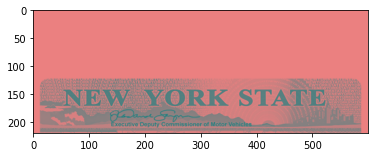

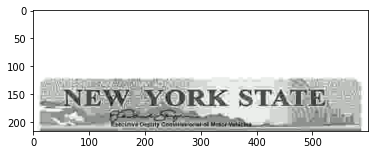

In [ ]:
%pylab inline
import scipy.misc
import cv2
img1 = cv2.imread('/content/driv2.pgm')
img = img1[0:220, 0:600]
w=8 #modify it if you want, maximal 8 due to default quantization table is 8*8
w=max(2,min(8,w))
h=w
xLen = img.shape[1]//w
yLen = img.shape[0]//h
runBits=1 #modify it if you want
bitBits=3  #modify it if you want
rbBits=runBits+bitBits ##(run,bitSize of coefficient)
useYCbCr=True #modify it if you want
useHuffman=True #modify it if you want
quantizationRatio=1 #modify it if you want, quantization table=default quantization table * quantizationRatio

from skimage.color import rgb2ycbcr,ycbcr2rgb
def myYcbcr2rgb(ycbcr):
  return (ycbcr2rgb(ycbcr).clip(0,1)*255).astype(uint8)
originalImg=copy(img)
ycbcr=rgb2ycbcr(img)
rgb=myYcbcr2rgb(ycbcr)
imshow(ycbcr.astype(uint8))
figure()
imshow(rgb)
if (useYCbCr):
  img=ycbcr
allclose(rgb,originalImg,atol=1)

def toBlocks(img):
  blocks = zeros((yLen,xLen,h,w,3),dtype=int16)
  for y in range(yLen):
    for x in range(xLen):
      blocks[y][x]=img[y*h:(y+1)*h,x*w:(x+1)*w]
  return array(blocks)
blocks = toBlocks(img)

from scipy.fftpack import dct,idct
def dctOrDedctAllBlocks(blocks,type="dct"):
  f=dct if type=="dct" else idct
  dedctBlocks = zeros((yLen,xLen,h,w,3))
  for y in range(yLen):
    for x in range(xLen):
      d = zeros((h,w,3))
      for i in range(3):
        block=blocks[y][x][:,:,i]
        d[:,:,i]=f(f(block.T, norm = 'ortho').T, norm = 'ortho')
        if (type!="dct"):
          d=d.round().astype(int16)
      dedctBlocks[y][x]=d
  return dedctBlocks
dctBlocks=dctOrDedctAllBlocks(blocks,"dct")

def blocks2img(blocks):
  W=xLen*w
  H=yLen*h
  img = zeros((H,W,3))
  for y in range(yLen):
    for x in range(xLen):
      img[y*h:y*h+h,x*w:x*w+w]=blocks[y][x]
  return img
newImg=blocks2img(dctBlocks)


#quantization table
QY=array([[16,11,10,16,24,40,51,61],
     [12,12,14,19,26,58,60,55],
     [14,13,16,24,40,57,69,56],
     [14,17,22,29,51,87,80,62],
     [18,22,37,56,68,109,103,77],
     [24,35,55,64,81,104,113,92],
     [49,64,78,87,103,121,120,101],
     [72,92,95,98,112,100,103,99]])
QC=array([[17,18,24,47,99,99,99,99],
     [18,21,26,66,99,99,99,99],
     [24,26,56,99,99,99,99,99],
     [47,66,99,99,99,99,99,99],
     [99,99,99,99,99,99,99,99],
     [99,99,99,99,99,99,99,99],
     [99,99,99,99,99,99,99,99],
     [99,99,99,99,99,99,99,99]])
QY=QY[:w,:h]
QC=QC[:w,:h]
qDctBlocks=copy(dctBlocks)
Q3 = moveaxis(array([QY]+[QC]+[QC]),0,2)*quantizationRatio if useYCbCr else dstack([QY*quantizationRatio]*3)#all r-g-b/Y-Cb-Cr 3 channels need to be quantized
Q3=Q3*((11-w)/3)
qDctBlocks=(qDctBlocks/Q3).round().astype('int16') 

qDctImg=blocks2img(qDctBlocks).astype('int16')
Qrandom=arange(200,200+w*h).reshape(w,h)
qRandDctBlocks=copy(dctBlocks)
Qr3 = dstack([Qrandom]*3)
qRandDctBlocks/=Qr3
qRandDctBlocks=qRandDctBlocks.round().astype('int16')
dedctBlocks=dctOrDedctAllBlocks(dctBlocks,"idct")
dedctBlocks=dctOrDedctAllBlocks(qDctBlocks*Q3,"idct")
dedctBlocks=dctOrDedctAllBlocks(qRandDctBlocks*Qr3,"idct")


def zigZag(block):
  lines=[[] for i in range(h+w-1)] 
  for y in range(h): 
    for x in range(w): 
      i=y+x 
      if(i%2 ==0): 
          lines[i].insert(0,block[y][x]) 
      else:  
          lines[i].append(block[y][x]) 
  return array([coefficient for line in lines for coefficient in line])
zigZag(qDctBlocks[0][0][:,:,0])


!pip install huffman
import huffman
from collections import Counter
def huffmanCounter(zigZagArr):
  rbCount=[]
  run=0
  for AC in zigZagArr[1:]:
    if(AC!=0):
      AC=max(AC,1-2**(2**bitBits-1)) if AC<0 else min(AC,2**(2**bitBits-1)-1)
      if(run>2**runBits-1):
        runGap=2**runBits
        k=run//runGap
        for i in range(k):
          rbCount.append('1'*runBits+'0'*bitBits)
        run-=k*runGap
      run=min(run,2**runBits-1) 
      bitSize=min(int(ceil(log(abs(AC)+0.000000001)/log(2))),2**bitBits-1)
      rbCount.append(format(run<<bitBits|bitSize,'0'+str(rbBits)+'b'))
      run=0
    else:
      run+=1
  rbCount.append("0"*(rbBits))
  return Counter(rbCount)
rbCount=zeros(3,dtype=Counter)
rbCount[0]=huffmanCounter(zigZag(qDctBlocks[0][0][:,:,0]))
rbCount[1]=huffmanCounter(zigZag(qDctBlocks[0][0][:,:,1]))
rbCount[2]=huffmanCounter(zigZag(qDctBlocks[0][0][:,:,2]))
rbCount=sum(rbCount)


def runLengthReadable(zigZagArr,lastDC):
  rlc=[]
  run=0
  newDC=min(zigZagArr[0],2**(2**bitBits-1)-1)
  DC=newDC-lastDC
  bitSize=max(0,min(int(ceil(log(abs(DC)+0.000000001)/log(2))),2**bitBits-1))
  rlc.append([array(bitSize),DC])
  code=format(bitSize, '0'+str(bitBits)+'b')+"\n"
  if (bitSize>0):
    code=code[:-1]+","+(format(DC,"b") if DC>0 else ''.join([str((int(b)^1)) for b in format(abs(DC),"b")]))+"\n"
  for AC in zigZagArr[1:]:
    if(AC!=0):
      AC=max(AC,1-2**(2**bitBits-1)) if AC<0 else min(AC,2**(2**bitBits-1)-1)
      if(run>2**runBits-1):
        runGap=2**runBits
        k=run//runGap
        for i in range(k):
          code+='1'*runBits+'0'*bitBits+'\n'
          rlc.append([runGap-1,0])
        run-=k*runGap
      bitSize=min(int(ceil(log(abs(AC)+0.000000001)/log(2))),2**bitBits-1)
      #VLI encoding (next 2 lines of codes)
      code+=format(run<<bitBits|bitSize,'0'+str(rbBits)+'b')+','
      code+=(format(AC,"b") if AC>=0 else ''.join([str((int(b)^1)) for b in format(abs(AC),"b")]))+"\n"
      rs=zeros(1,dtype=object)
      rs[0]=array([run,bitSize])
      rs= append(rs,AC)
      rlc.append(rs)
      run=0
    else:
      run+=1
  rlc.append([0,0])
  code+="0"*(rbBits)#end
  return array(rlc),code,newDC
b=zeros(64,dtype=int16)
b[0]=222
b[4]=9
b[11]=33
b[12]=25
b[14]=-129
b[17]=77
b[27]=12
b[47]=82
print(b)
arr,code,DC=runLengthReadable(b,0)


def runLength(zigZagArr,lastDC,hfm=None):
  rlc=[]
  run=0
  newDC=min(zigZagArr[0],2**(2**bitBits-1))
  DC=newDC-lastDC
  bitSize=max(0,min(int(ceil(log(abs(DC)+0.000000001)/log(2))),2**bitBits-1))
  code=format(bitSize, '0'+str(bitBits)+'b')
  if (bitSize>0):
   code+=(format(DC,"b") if DC>0 else ''.join([str((int(b)^1)) for b in format(abs(DC),"b")]))
  for AC in zigZagArr[1:]:
    if(AC!=0):
      AC=max(AC,1-2**(2**bitBits-1)) if AC<0 else min(AC,2**(2**bitBits-1)-1)
      if(run>2**runBits-1):
        runGap=2**runBits
        k=run//runGap
        for i in range(k):
          code+=('1'*runBits+'0'*bitBits)if hfm == None else  hfm['1'*runBits+'0'*bitBits]#end
        run-=k*runGap
      run=min(run,2**runBits-1) 
      bitSize=min(int(ceil(log(abs(AC)+0.000000001)/log(2))),2**bitBits-1)
      rb=format(run<<bitBits|bitSize,'0'+str(rbBits)+'b') if hfm == None else hfm[format(run<<bitBits|bitSize,'0'+str(rbBits)+'b')]
      code+=rb+(format(AC,"b") if AC>=0 else ''.join([str((int(b)^1)) for b in format(abs(AC),"b")]))
      run=0
    else:
      run+=1
  code+="0"*(rbBits) if hfm == None else  hfm["0"*(rbBits)]#end
  return code,newDC
code1,DC=runLength(zigZag(qDctBlocks[0][0][:,:,0]),0)
code2,DC=runLength(zigZag(qDctBlocks[0][0][:,:,1]),DC)
code3,DC=runLength(zigZag(qDctBlocks[0][0][:,:,2]),DC)
codeBlock=code1+code2+code3

def runLength2bytes(code):
  return bytes([len(code)%8]+[int(code[i:i+8],2) for i in range(0, len(code), 8)])

def huffmanCounterWholeImg(blocks):
  rbCount=zeros(xLen*yLen*3,dtype=Counter)
  zz=zeros(xLen*yLen*3,dtype=object)
  for y in range(yLen):
    for x in range(xLen):
      for i in range(3):
        zz[y*xLen*3+x*3+i]=zigZag(blocks[y, x,:,:,i])
        rbCount[y*xLen*3+x*3+i]=huffmanCounter(zz[y*xLen*3+x*3+i])
  return sum(rbCount),zz
rbCount,zz=huffmanCounterWholeImg(qDctBlocks)
hfm=huffman.codebook(rbCount.items())
sortedHfm=[[hfm[i[0]],i[0],rbCount[i[0]]] for i in rbCount.most_common()]

def savingQuantizedDctBlocks(blocks):
  rbCount,zigZag=huffmanCounterWholeImg(blocks)
  hfm=huffman.codebook(rbCount.items())
  sortedHfm=[[hfm[i[0]],i[0]] for i in rbCount.most_common()]
  code=""
  DC=0
  for y in range(yLen):
    for x in range(xLen):
      for i in range(3):
        codeNew,DC=runLength(zigZag[y*xLen*3+x*3+i],DC,hfm if useHuffman else None)
        code+=codeNew
  savedImg=runLength2bytes(code)
  print(str(code[:100])+"......")
  print(str(savedImg[:20])+"......")
  print("Image original size:    %.3f MB"%(img.size/(2**20)))
  print("Compression image size: %.3f MB"%(len(savedImg)/2**20))
  print("Compression ratio:      %.2f : 1"%(img.size/2**20/(len(savedImg)/2**20)))
  c1= (img.size/2**20/(len(savedImg)/2**20))
  return bytes([int(format(xLen,'012b')[:8],2),int(format(xLen,'012b')[8:]+format(yLen,'012b')[:4],2),int(format(yLen,'012b')[4:],2)])+savedImg,sortedHfm,c1
import time
t1=time.time()
savedImg,sortedHfmForDecode,C2=savingQuantizedDctBlocks(qDctBlocks)
t2=time.time()
save = open("img.bin", "wb")
save.write(savedImg)
save.close()


qr=10
qDctBlocks5=copy(dctBlocks)
Q3_5 = Q3*qr
qDctBlocks5=(qDctBlocks5/Q3_5).round().astype('int16')
dedctBlocks=dctOrDedctAllBlocks(dctBlocks,"idct")
dedctBlocks=dctOrDedctAllBlocks(qDctBlocks5*Q3_5,"idct")
savedImg1,rbCount1,C2_1=savingQuantizedDctBlocks(qDctBlocks5)
save = open("img5foldCompression.bin", "wb")
save.write(savedImg1)
save.close()

def bytes2runLength(bytes):
  return "".join([format(i,'08b') for i in list(bytes)][1:-1 if list(bytes)[-1]!=0 else None])+(format(list(bytes)[-1],'0'+str(list(bytes)[0])+'b')if list(bytes)[-1]!=0 else"")

gaps=[i for i in range(1,8)]+[8-i for i in range(8)]+[-1]
locations=[[int(sum(range(gaps[i-1]+1))),sum(range(gaps[i]+1))] if gaps[i]>gaps[i-1]  else [64-sum(range(gaps[i-1])),64-sum(range(gaps[i]))] for i in range(len(gaps)-1)]
def deZigZag(zigZagArr):
  zigZagArr=[zigZagArr[l[0]:l[1]] for l in locations]
  block=zeros((h,w),dtype=int16)
  for y in range(h): 
    for x in range(w): 
      i=y+x 
      if(i%2 != 0): 
        block[y][x]=zigZagArr[i][0]
        zigZagArr[i]=zigZagArr[i][1:]
      else: 
        block[y][x]=zigZagArr[i][-1:][0]
        zigZagArr[i]=zigZagArr[i][:-1]
  return block


  #explaination of above section of codes
z=zigZag(qDctBlocks[0][0][:,:,0])
gaps=[ i for i in range(1,w)]+[w-i for i in range(w)]+[-1]
locations=[[int(sum(range(gaps[i-1]+1))),sum(range(gaps[i]+1))] if gaps[i]>gaps[i-1]  else [w*h-sum(range(gaps[i-1])),w*h-sum(range(gaps[i]))] for i in range(len(gaps)-1)]
zz1=[z[l[0]:l[1]] for l in locations]
for i in range(len(zz1)): 
  print(zz1[i])


if(w%2==0):
  x=concatenate([append(arange(0,i),arange(0,i)[::-1][1:]) for i in range(2,w+1,2)])
  x=append(x,(w-1-x[::-1])[w:])
  y=concatenate([append(arange(0,i),arange(0,i)[::-1][1:]) for i in range(1,w+1,2)])
  y=append(append(y,arange(0,h)),(h-1-y[::-1]))
else:
  x=concatenate([append(arange(0,i),arange(0,i)[::-1][1:]) for i in range(2,w,2)])
  x=append(append(x,arange(0,w)),w-1-x[::-1])
  y=concatenate([append(arange(0,i),arange(0,i)[::-1][1:]) for i in range(1,w+2,2)])
  y=append(y[:-w],w-1-y[::-1])
zzLine=dstack([x]+[y])[0]
zzMatrix=zeros((w,h),dtype=int8)
for i in range(len(zzLine)):
  zzMatrix[zzLine[i][1]][zzLine[i][0]]=i


def deZigZag2(zigZagArr):
  block=zeros((h,w),dtype=int16)
  for i in range(len(zzLine)):
    block[zzLine[i][1],zzLine[i][0]]=zigZagArr[i]
  return block
deZigZag2(zigZag(qDctBlocks[0][0][:,:,0]))


load = open("img.bin", "rb")
loadedbytes = load.read()
code=bytes2runLength(loadedbytes[2:])

def loadingQuantizedDctBlocks(loadedbytes,sortedHfm=None):
  runMax=2**runBits-1
  xLen=int(format(loadedbytes[0],'b')+format(loadedbytes[1],'08b')[:4],2)
  yLen=int(format(loadedbytes[1],'08b')[4:]+format(loadedbytes[2],'08b'),2)
  code=bytes2runLength(loadedbytes[3:])
  blocks = zeros((yLen,xLen,h,w,3),dtype=int16)
  lastDC=0
  rbBitsTmp=rbBits
  rbTmp=""
  cursor=0 #don't use code=code[index:] to remove readed strings when len(String) is large like 1,000,000. It will be extremely slow
  for y in range(yLen):
    for x in range(xLen):
      for i in range(3):
        zz=zeros(64)
        bitSize=int(code[cursor:cursor+bitBits],2)
        DC=code[cursor+bitBits:cursor+bitBits+bitSize]
        DC=(int(DC,2) if DC[0]=="1" else -int(''.join([str((int(b)^1)) for b in DC]),2)) if bitSize>0 else 0
        cursor+=(bitBits+bitSize)
        zz[0]=DC+lastDC
        lastDC=zz[0]
        r=1
        while(True):
          if(sortedHfm!=None):
            for ii in sortedHfm:
              if (ii[0]==code[cursor:cursor+len(ii[0])]):
                rbTmp=ii[1]
                rbBitsTmp=len(ii[0])
                break
            run=int(rbTmp[:runBits],2)
            bitSize=int(rbTmp[runBits:],2)
          else:
            run=int(code[cursor:cursor+runBits],2)
            bitSize=int(code[cursor+runBits:cursor+rbBitsTmp],2)
          if (bitSize==0):
            cursor+=rbBitsTmp
            if(run==runMax):
              r+=(run+1)
              continue
            else:
              break
          coefficient=code[cursor+rbBitsTmp:cursor+rbBitsTmp+bitSize]
          if(coefficient[0]=="0"):
            coefficient=-int(''.join([str((int(b)^1)) for b in coefficient]),2)
          else:
            coefficient=int(coefficient,2)
          zz[r+run]=coefficient
          r+=(run+1)
          cursor+=rbBitsTmp+bitSize    
        blocks[y,x,...,i]=deZigZag2(zz)
  return blocks
t1=time.time()
loadedBlocks=loadingQuantizedDctBlocks(loadedbytes,sortedHfmForDecode if useHuffman else None)
t2=time.time()

incorrect=qDctBlocks.size-count_nonzero((qDctBlocks==loadedBlocks)==True)
loadedDctImg=blocks2img(loadedBlocks)
deDctLoadedBlocks=dctOrDedctAllBlocks(loadedBlocks*Q3,"idct")
loadedImg=blocks2img(deDctLoadedBlocks)

#explaination of above section of codes
z1=zigZag(qDctBlocks5[0][0][:,:,0])
gaps1=[ i for i in range(1,w)]+[w-i for i in range(w)]+[-1]
locations1=[[int(sum(range(gaps1[i-1]+1))),sum(range(gaps1[i]+1))] if gaps1[i]>gaps1[i-1]  else [w*h-sum(range(gaps1[i-1])),w*h-sum(range(gaps1[i]))] for i in range(len(gaps1)-1)]
zz1_1=[z1[l[0]:l[1]] for l in locations1]
for i in range(len(zz1_1)): 
  print(zz1_1[i])

load1 = open("img5foldCompression.bin", "rb")
loadedbytes1 = load1.read()
code1=bytes2runLength(loadedbytes1[2:])

t1_1=time.time()
loadedBlocks1=loadingQuantizedDctBlocks(loadedbytes1,rbCount1 if useHuffman else None)
t2_1=time.time()


incorrect_1=qDctBlocks5.size-count_nonzero((qDctBlocks5==loadedBlocks1)==True)
loadedDctImg1=blocks2img(loadedBlocks1)
deDctLoadedBlocks1=dctOrDedctAllBlocks(loadedBlocks1*Q3_5,"idct")
loadedImg1=blocks2img(deDctLoadedBlocks1)
img2 = (myYcbcr2rgb(loadedImg1) if useYCbCr else blocks2img(dedctBlocks).astype(int16))
imshow(img2)

In [ ]:
A2 = img2.shape[0]*img2.shape[1]
print("area of text part1:",A2)
print("Compression ratio for A2:  %.2f : 1"%(C2_1))

area of text part1: 129600
Compression ratio for A2:  69.41 : 1


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['qr', 'save', 'load']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


[ 222    0    0    0    9    0    0    0    0    0    0   33   25    0
 -129    0    0   77    0    0    0    0    0    0    0    0    0   12
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0   82    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
1111110110011000010100000110110101100011011110100110011111001010111011111111100011000101000000110101......
b'\x07\xfd\x98Pmczg\xca\xef\xf8\xc5\x03_o\xb6\xfd\xca\xd6\xbf'......
Image original size:    0.216 MB
Compression image size: 0.005 MB
Compression ratio:      39.67 : 1
1001100101100110001011101001101101010001011101101101010001011101101101010001011101101101010001011101......
b'\x06\x99f.\x9bQv\xd4]\xb5\x17mE\xdbQv\xd4]\xb5\x17'......
Image original size:    0.216 MB
Compression image size: 0.003 MB
Compression ratio:      85.23 : 1
[118]
[0 0]
[0 0 0]
[0 0 0 0]
[0 0 0 0 0]
[0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0]
[0 0 0 0 0]

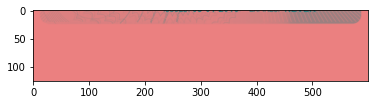

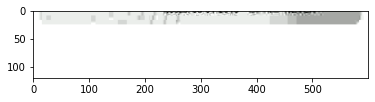

In [ ]:
%pylab inline
import scipy.misc
import cv2
img1 = cv2.imread('/content/driv2.pgm')
img = img1[474:600, 0:600]
w=8 #modify it if you want, maximal 8 due to default quantization table is 8*8
w=max(2,min(8,w))
h=w
xLen = img.shape[1]//w
yLen = img.shape[0]//h
runBits=1 #modify it if you want
bitBits=3  #modify it if you want
rbBits=runBits+bitBits ##(run,bitSize of coefficient)
useYCbCr=True #modify it if you want
useHuffman=True #modify it if you want
quantizationRatio=1 #modify it if you want, quantization table=default quantization table * quantizationRatio

from skimage.color import rgb2ycbcr,ycbcr2rgb
def myYcbcr2rgb(ycbcr):
  return (ycbcr2rgb(ycbcr).clip(0,1)*255).astype(uint8)
originalImg=copy(img)
ycbcr=rgb2ycbcr(img)
rgb=myYcbcr2rgb(ycbcr)
imshow(ycbcr.astype(uint8))
figure()
imshow(rgb)
if (useYCbCr):
  img=ycbcr
allclose(rgb,originalImg,atol=1)

def toBlocks(img):
  blocks = zeros((yLen,xLen,h,w,3),dtype=int16)
  for y in range(yLen):
    for x in range(xLen):
      blocks[y][x]=img[y*h:(y+1)*h,x*w:(x+1)*w]
  return array(blocks)
blocks = toBlocks(img)

from scipy.fftpack import dct,idct
def dctOrDedctAllBlocks(blocks,type="dct"):
  f=dct if type=="dct" else idct
  dedctBlocks = zeros((yLen,xLen,h,w,3))
  for y in range(yLen):
    for x in range(xLen):
      d = zeros((h,w,3))
      for i in range(3):
        block=blocks[y][x][:,:,i]
        d[:,:,i]=f(f(block.T, norm = 'ortho').T, norm = 'ortho')
        if (type!="dct"):
          d=d.round().astype(int16)
      dedctBlocks[y][x]=d
  return dedctBlocks
dctBlocks=dctOrDedctAllBlocks(blocks,"dct")

def blocks2img(blocks):
  W=xLen*w
  H=yLen*h
  img = zeros((H,W,3))
  for y in range(yLen):
    for x in range(xLen):
      img[y*h:y*h+h,x*w:x*w+w]=blocks[y][x]
  return img
newImg=blocks2img(dctBlocks)


#quantization table
QY=array([[16,11,10,16,24,40,51,61],
     [12,12,14,19,26,58,60,55],
     [14,13,16,24,40,57,69,56],
     [14,17,22,29,51,87,80,62],
     [18,22,37,56,68,109,103,77],
     [24,35,55,64,81,104,113,92],
     [49,64,78,87,103,121,120,101],
     [72,92,95,98,112,100,103,99]])
QC=array([[17,18,24,47,99,99,99,99],
     [18,21,26,66,99,99,99,99],
     [24,26,56,99,99,99,99,99],
     [47,66,99,99,99,99,99,99],
     [99,99,99,99,99,99,99,99],
     [99,99,99,99,99,99,99,99],
     [99,99,99,99,99,99,99,99],
     [99,99,99,99,99,99,99,99]])
QY=QY[:w,:h]
QC=QC[:w,:h]
qDctBlocks=copy(dctBlocks)
Q3 = moveaxis(array([QY]+[QC]+[QC]),0,2)*quantizationRatio if useYCbCr else dstack([QY*quantizationRatio]*3)#all r-g-b/Y-Cb-Cr 3 channels need to be quantized
Q3=Q3*((11-w)/3)
qDctBlocks=(qDctBlocks/Q3).round().astype('int16') 

qDctImg=blocks2img(qDctBlocks).astype('int16')
Qrandom=arange(200,200+w*h).reshape(w,h)
qRandDctBlocks=copy(dctBlocks)
Qr3 = dstack([Qrandom]*3)
qRandDctBlocks/=Qr3
qRandDctBlocks=qRandDctBlocks.round().astype('int16')
dedctBlocks=dctOrDedctAllBlocks(dctBlocks,"idct")
dedctBlocks=dctOrDedctAllBlocks(qDctBlocks*Q3,"idct")
dedctBlocks=dctOrDedctAllBlocks(qRandDctBlocks*Qr3,"idct")


def zigZag(block):
  lines=[[] for i in range(h+w-1)] 
  for y in range(h): 
    for x in range(w): 
      i=y+x 
      if(i%2 ==0): 
          lines[i].insert(0,block[y][x]) 
      else:  
          lines[i].append(block[y][x]) 
  return array([coefficient for line in lines for coefficient in line])
zigZag(qDctBlocks[0][0][:,:,0])


!pip install huffman
import huffman
from collections import Counter
def huffmanCounter(zigZagArr):
  rbCount=[]
  run=0
  for AC in zigZagArr[1:]:
    if(AC!=0):
      AC=max(AC,1-2**(2**bitBits-1)) if AC<0 else min(AC,2**(2**bitBits-1)-1)
      if(run>2**runBits-1):
        runGap=2**runBits
        k=run//runGap
        for i in range(k):
          rbCount.append('1'*runBits+'0'*bitBits)
        run-=k*runGap
      run=min(run,2**runBits-1) 
      bitSize=min(int(ceil(log(abs(AC)+0.000000001)/log(2))),2**bitBits-1)
      rbCount.append(format(run<<bitBits|bitSize,'0'+str(rbBits)+'b'))
      run=0
    else:
      run+=1
  rbCount.append("0"*(rbBits))
  return Counter(rbCount)
rbCount=zeros(3,dtype=Counter)
rbCount[0]=huffmanCounter(zigZag(qDctBlocks[0][0][:,:,0]))
rbCount[1]=huffmanCounter(zigZag(qDctBlocks[0][0][:,:,1]))
rbCount[2]=huffmanCounter(zigZag(qDctBlocks[0][0][:,:,2]))
rbCount=sum(rbCount)


def runLengthReadable(zigZagArr,lastDC):
  rlc=[]
  run=0
  newDC=min(zigZagArr[0],2**(2**bitBits-1)-1)
  DC=newDC-lastDC
  bitSize=max(0,min(int(ceil(log(abs(DC)+0.000000001)/log(2))),2**bitBits-1))
  rlc.append([array(bitSize),DC])
  code=format(bitSize, '0'+str(bitBits)+'b')+"\n"
  if (bitSize>0):
    code=code[:-1]+","+(format(DC,"b") if DC>0 else ''.join([str((int(b)^1)) for b in format(abs(DC),"b")]))+"\n"
  for AC in zigZagArr[1:]:
    if(AC!=0):
      AC=max(AC,1-2**(2**bitBits-1)) if AC<0 else min(AC,2**(2**bitBits-1)-1)
      if(run>2**runBits-1):
        runGap=2**runBits
        k=run//runGap
        for i in range(k):
          code+='1'*runBits+'0'*bitBits+'\n'
          rlc.append([runGap-1,0])
        run-=k*runGap
      bitSize=min(int(ceil(log(abs(AC)+0.000000001)/log(2))),2**bitBits-1)
      #VLI encoding (next 2 lines of codes)
      code+=format(run<<bitBits|bitSize,'0'+str(rbBits)+'b')+','
      code+=(format(AC,"b") if AC>=0 else ''.join([str((int(b)^1)) for b in format(abs(AC),"b")]))+"\n"
      rs=zeros(1,dtype=object)
      rs[0]=array([run,bitSize])
      rs= append(rs,AC)
      rlc.append(rs)
      run=0
    else:
      run+=1
  rlc.append([0,0])
  code+="0"*(rbBits)#end
  return array(rlc),code,newDC
b=zeros(64,dtype=int16)
b[0]=222
b[4]=9
b[11]=33
b[12]=25
b[14]=-129
b[17]=77
b[27]=12
b[47]=82
print(b)
arr,code,DC=runLengthReadable(b,0)


def runLength(zigZagArr,lastDC,hfm=None):
  rlc=[]
  run=0
  newDC=min(zigZagArr[0],2**(2**bitBits-1))
  DC=newDC-lastDC
  bitSize=max(0,min(int(ceil(log(abs(DC)+0.000000001)/log(2))),2**bitBits-1))
  code=format(bitSize, '0'+str(bitBits)+'b')
  if (bitSize>0):
   code+=(format(DC,"b") if DC>0 else ''.join([str((int(b)^1)) for b in format(abs(DC),"b")]))
  for AC in zigZagArr[1:]:
    if(AC!=0):
      AC=max(AC,1-2**(2**bitBits-1)) if AC<0 else min(AC,2**(2**bitBits-1)-1)
      if(run>2**runBits-1):
        runGap=2**runBits
        k=run//runGap
        for i in range(k):
          code+=('1'*runBits+'0'*bitBits)if hfm == None else  hfm['1'*runBits+'0'*bitBits]#end
        run-=k*runGap
      run=min(run,2**runBits-1) 
      bitSize=min(int(ceil(log(abs(AC)+0.000000001)/log(2))),2**bitBits-1)
      rb=format(run<<bitBits|bitSize,'0'+str(rbBits)+'b') if hfm == None else hfm[format(run<<bitBits|bitSize,'0'+str(rbBits)+'b')]
      code+=rb+(format(AC,"b") if AC>=0 else ''.join([str((int(b)^1)) for b in format(abs(AC),"b")]))
      run=0
    else:
      run+=1
  code+="0"*(rbBits) if hfm == None else  hfm["0"*(rbBits)]#end
  return code,newDC
code1,DC=runLength(zigZag(qDctBlocks[0][0][:,:,0]),0)
code2,DC=runLength(zigZag(qDctBlocks[0][0][:,:,1]),DC)
code3,DC=runLength(zigZag(qDctBlocks[0][0][:,:,2]),DC)
codeBlock=code1+code2+code3

def runLength2bytes(code):
  return bytes([len(code)%8]+[int(code[i:i+8],2) for i in range(0, len(code), 8)])

def huffmanCounterWholeImg(blocks):
  rbCount=zeros(xLen*yLen*3,dtype=Counter)
  zz=zeros(xLen*yLen*3,dtype=object)
  for y in range(yLen):
    for x in range(xLen):
      for i in range(3):
        zz[y*xLen*3+x*3+i]=zigZag(blocks[y, x,:,:,i])
        rbCount[y*xLen*3+x*3+i]=huffmanCounter(zz[y*xLen*3+x*3+i])
  return sum(rbCount),zz
rbCount,zz=huffmanCounterWholeImg(qDctBlocks)
hfm=huffman.codebook(rbCount.items())
sortedHfm=[[hfm[i[0]],i[0],rbCount[i[0]]] for i in rbCount.most_common()]

def savingQuantizedDctBlocks(blocks):
  rbCount,zigZag=huffmanCounterWholeImg(blocks)
  hfm=huffman.codebook(rbCount.items())
  sortedHfm=[[hfm[i[0]],i[0]] for i in rbCount.most_common()]
  code=""
  DC=0
  for y in range(yLen):
    for x in range(xLen):
      for i in range(3):
        codeNew,DC=runLength(zigZag[y*xLen*3+x*3+i],DC,hfm if useHuffman else None)
        code+=codeNew
  savedImg=runLength2bytes(code)
  print(str(code[:100])+"......")
  print(str(savedImg[:20])+"......")
  print("Image original size:    %.3f MB"%(img.size/(2**20)))
  print("Compression image size: %.3f MB"%(len(savedImg)/2**20))
  print("Compression ratio:      %.2f : 1"%(img.size/2**20/(len(savedImg)/2**20)))
  c1 = (img.size/2**20/(len(savedImg)/2**20))
  return bytes([int(format(xLen,'012b')[:8],2),int(format(xLen,'012b')[8:]+format(yLen,'012b')[:4],2),int(format(yLen,'012b')[4:],2)])+savedImg,sortedHfm,c1
import time
t1=time.time()
savedImg,sortedHfmForDecode,C3=savingQuantizedDctBlocks(qDctBlocks)
t2=time.time()
save = open("img.bin", "wb")
save.write(savedImg)
save.close()


qr=10
qDctBlocks5=copy(dctBlocks)
Q3_5 = Q3*qr
qDctBlocks5=(qDctBlocks5/Q3_5).round().astype('int16')
dedctBlocks=dctOrDedctAllBlocks(dctBlocks,"idct")
dedctBlocks=dctOrDedctAllBlocks(qDctBlocks5*Q3_5,"idct")
savedImg1,rbCount1,C3_1=savingQuantizedDctBlocks(qDctBlocks5)
save = open("img5foldCompression.bin", "wb")
save.write(savedImg1)
save.close()

def bytes2runLength(bytes):
  return "".join([format(i,'08b') for i in list(bytes)][1:-1 if list(bytes)[-1]!=0 else None])+(format(list(bytes)[-1],'0'+str(list(bytes)[0])+'b')if list(bytes)[-1]!=0 else"")

gaps=[i for i in range(1,8)]+[8-i for i in range(8)]+[-1]
locations=[[int(sum(range(gaps[i-1]+1))),sum(range(gaps[i]+1))] if gaps[i]>gaps[i-1]  else [64-sum(range(gaps[i-1])),64-sum(range(gaps[i]))] for i in range(len(gaps)-1)]
def deZigZag(zigZagArr):
  zigZagArr=[zigZagArr[l[0]:l[1]] for l in locations]
  block=zeros((h,w),dtype=int16)
  for y in range(h): 
    for x in range(w): 
      i=y+x 
      if(i%2 != 0): 
        block[y][x]=zigZagArr[i][0]
        zigZagArr[i]=zigZagArr[i][1:]
      else: 
        block[y][x]=zigZagArr[i][-1:][0]
        zigZagArr[i]=zigZagArr[i][:-1]
  return block


  #explaination of above section of codes
z=zigZag(qDctBlocks[0][0][:,:,0])
gaps=[ i for i in range(1,w)]+[w-i for i in range(w)]+[-1]
locations=[[int(sum(range(gaps[i-1]+1))),sum(range(gaps[i]+1))] if gaps[i]>gaps[i-1]  else [w*h-sum(range(gaps[i-1])),w*h-sum(range(gaps[i]))] for i in range(len(gaps)-1)]
zz1=[z[l[0]:l[1]] for l in locations]
for i in range(len(zz1)): 
  print(zz1[i])


if(w%2==0):
  x=concatenate([append(arange(0,i),arange(0,i)[::-1][1:]) for i in range(2,w+1,2)])
  x=append(x,(w-1-x[::-1])[w:])
  y=concatenate([append(arange(0,i),arange(0,i)[::-1][1:]) for i in range(1,w+1,2)])
  y=append(append(y,arange(0,h)),(h-1-y[::-1]))
else:
  x=concatenate([append(arange(0,i),arange(0,i)[::-1][1:]) for i in range(2,w,2)])
  x=append(append(x,arange(0,w)),w-1-x[::-1])
  y=concatenate([append(arange(0,i),arange(0,i)[::-1][1:]) for i in range(1,w+2,2)])
  y=append(y[:-w],w-1-y[::-1])
zzLine=dstack([x]+[y])[0]
zzMatrix=zeros((w,h),dtype=int8)
for i in range(len(zzLine)):
  zzMatrix[zzLine[i][1]][zzLine[i][0]]=i


def deZigZag2(zigZagArr):
  block=zeros((h,w),dtype=int16)
  for i in range(len(zzLine)):
    block[zzLine[i][1],zzLine[i][0]]=zigZagArr[i]
  return block
deZigZag2(zigZag(qDctBlocks[0][0][:,:,0]))


load = open("img.bin", "rb")
loadedbytes = load.read()
code=bytes2runLength(loadedbytes[2:])

def loadingQuantizedDctBlocks(loadedbytes,sortedHfm=None):
  runMax=2**runBits-1
  xLen=int(format(loadedbytes[0],'b')+format(loadedbytes[1],'08b')[:4],2)
  yLen=int(format(loadedbytes[1],'08b')[4:]+format(loadedbytes[2],'08b'),2)
  code=bytes2runLength(loadedbytes[3:])
  blocks = zeros((yLen,xLen,h,w,3),dtype=int16)
  lastDC=0
  rbBitsTmp=rbBits
  rbTmp=""
  cursor=0 #don't use code=code[index:] to remove readed strings when len(String) is large like 1,000,000. It will be extremely slow
  for y in range(yLen):
    for x in range(xLen):
      for i in range(3):
        zz=zeros(64)
        bitSize=int(code[cursor:cursor+bitBits],2)
        DC=code[cursor+bitBits:cursor+bitBits+bitSize]
        DC=(int(DC,2) if DC[0]=="1" else -int(''.join([str((int(b)^1)) for b in DC]),2)) if bitSize>0 else 0
        cursor+=(bitBits+bitSize)
        zz[0]=DC+lastDC
        lastDC=zz[0]
        r=1
        while(True):
          if(sortedHfm!=None):
            for ii in sortedHfm:
              if (ii[0]==code[cursor:cursor+len(ii[0])]):
                rbTmp=ii[1]
                rbBitsTmp=len(ii[0])
                break
            run=int(rbTmp[:runBits],2)
            bitSize=int(rbTmp[runBits:],2)
          else:
            run=int(code[cursor:cursor+runBits],2)
            bitSize=int(code[cursor+runBits:cursor+rbBitsTmp],2)
          if (bitSize==0):
            cursor+=rbBitsTmp
            if(run==runMax):
              r+=(run+1)
              continue
            else:
              break
          coefficient=code[cursor+rbBitsTmp:cursor+rbBitsTmp+bitSize]
          if(coefficient[0]=="0"):
            coefficient=-int(''.join([str((int(b)^1)) for b in coefficient]),2)
          else:
            coefficient=int(coefficient,2)
          zz[r+run]=coefficient
          r+=(run+1)
          cursor+=rbBitsTmp+bitSize    
        blocks[y,x,...,i]=deZigZag2(zz)
  return blocks
t1=time.time()
loadedBlocks=loadingQuantizedDctBlocks(loadedbytes,sortedHfmForDecode if useHuffman else None)
t2=time.time()

incorrect=qDctBlocks.size-count_nonzero((qDctBlocks==loadedBlocks)==True)
loadedDctImg=blocks2img(loadedBlocks)
deDctLoadedBlocks=dctOrDedctAllBlocks(loadedBlocks*Q3,"idct")
loadedImg=blocks2img(deDctLoadedBlocks)

#explaination of above section of codes
z1=zigZag(qDctBlocks5[0][0][:,:,0])
gaps1=[ i for i in range(1,w)]+[w-i for i in range(w)]+[-1]
locations1=[[int(sum(range(gaps1[i-1]+1))),sum(range(gaps1[i]+1))] if gaps1[i]>gaps1[i-1]  else [w*h-sum(range(gaps1[i-1])),w*h-sum(range(gaps1[i]))] for i in range(len(gaps1)-1)]
zz1_1=[z1[l[0]:l[1]] for l in locations1]
for i in range(len(zz1_1)): 
  print(zz1_1[i])

load1 = open("img5foldCompression.bin", "rb")
loadedbytes1 = load1.read()
code1=bytes2runLength(loadedbytes1[2:])

t1_1=time.time()
loadedBlocks1=loadingQuantizedDctBlocks(loadedbytes1,rbCount1 if useHuffman else None)
t2_1=time.time()


incorrect_1=qDctBlocks5.size-count_nonzero((qDctBlocks5==loadedBlocks1)==True)
loadedDctImg1=blocks2img(loadedBlocks1)
deDctLoadedBlocks1=dctOrDedctAllBlocks(loadedBlocks1*Q3_5,"idct")
loadedImg1=blocks2img(deDctLoadedBlocks1)
img3 = (myYcbcr2rgb(loadedImg1) if useYCbCr else blocks2img(dedctBlocks).astype(int16))
imshow(img3)

In [ ]:
A3 = img3.shape[0]*img3.shape[1]
print("area of text part2:",A3)
print("Compression ratio for A3:  %.2f : 1"%(C3_1))

area of text part2: 72000
Compression ratio for A3:  85.23 : 1


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['qr', 'save', 'load']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


[ 222    0    0    0    9    0    0    0    0    0    0   33   25    0
 -129    0    0   77    0    0    0    0    0    0    0    0    0   12
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0   82    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
1111110110111100001011100011110110010100111101100110101000011000011010010110111111000110111000111101......
b'\x02\xfd\xbc.=\x94\xf6j\x18io\xc6\xe3\xddx\\{)\xee\xa6'......
Image original size:    0.015 MB
Compression image size: 0.000 MB
Compression ratio:      40.53 : 1
1001100101100110001011101011011010100010111101011001100010111010110110101000101111010110011000101110......
b'\x03\x99f.\xb6\xa2\xf5\x98\xba\xda\x8b\xd6b\xebj/Y\x8b\xad\xa8'......
Image original size:    0.015 MB
Compression image size: 0.000 MB
Compression ratio:      102.28 : 1
[118]
[0 0]
[0 0 0]
[0 0 0 0]
[0 0 0 0 0]
[0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0]
[0 

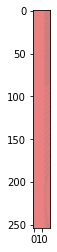

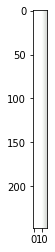

In [ ]:
%pylab inline
import scipy.misc
import cv2
img1 = cv2.imread('/content/driv2.pgm')
img = img1[220:474, 0:20]
w=8 #modify it if you want, maximal 8 due to default quantization table is 8*8
w=max(2,min(8,w))
h=w
xLen = img.shape[1]//w
yLen = img.shape[0]//h
runBits=1 #modify it if you want
bitBits=3  #modify it if you want
rbBits=runBits+bitBits ##(run,bitSize of coefficient)
useYCbCr=True #modify it if you want
useHuffman=True #modify it if you want
quantizationRatio=1 #modify it if you want, quantization table=default quantization table * quantizationRatio

from skimage.color import rgb2ycbcr,ycbcr2rgb
def myYcbcr2rgb(ycbcr):
  return (ycbcr2rgb(ycbcr).clip(0,1)*255).astype(uint8)
originalImg=copy(img)
ycbcr=rgb2ycbcr(img)
rgb=myYcbcr2rgb(ycbcr)
imshow(ycbcr.astype(uint8))
figure()
imshow(rgb)
if (useYCbCr):
  img=ycbcr
allclose(rgb,originalImg,atol=1)

def toBlocks(img):
  blocks = zeros((yLen,xLen,h,w,3),dtype=int16)
  for y in range(yLen):
    for x in range(xLen):
      blocks[y][x]=img[y*h:(y+1)*h,x*w:(x+1)*w]
  return array(blocks)
blocks = toBlocks(img)

from scipy.fftpack import dct,idct
def dctOrDedctAllBlocks(blocks,type="dct"):
  f=dct if type=="dct" else idct
  dedctBlocks = zeros((yLen,xLen,h,w,3))
  for y in range(yLen):
    for x in range(xLen):
      d = zeros((h,w,3))
      for i in range(3):
        block=blocks[y][x][:,:,i]
        d[:,:,i]=f(f(block.T, norm = 'ortho').T, norm = 'ortho')
        if (type!="dct"):
          d=d.round().astype(int16)
      dedctBlocks[y][x]=d
  return dedctBlocks
dctBlocks=dctOrDedctAllBlocks(blocks,"dct")

def blocks2img(blocks):
  W=xLen*w
  H=yLen*h
  img = zeros((H,W,3))
  for y in range(yLen):
    for x in range(xLen):
      img[y*h:y*h+h,x*w:x*w+w]=blocks[y][x]
  return img
newImg=blocks2img(dctBlocks)


#quantization table
QY=array([[16,11,10,16,24,40,51,61],
     [12,12,14,19,26,58,60,55],
     [14,13,16,24,40,57,69,56],
     [14,17,22,29,51,87,80,62],
     [18,22,37,56,68,109,103,77],
     [24,35,55,64,81,104,113,92],
     [49,64,78,87,103,121,120,101],
     [72,92,95,98,112,100,103,99]])
QC=array([[17,18,24,47,99,99,99,99],
     [18,21,26,66,99,99,99,99],
     [24,26,56,99,99,99,99,99],
     [47,66,99,99,99,99,99,99],
     [99,99,99,99,99,99,99,99],
     [99,99,99,99,99,99,99,99],
     [99,99,99,99,99,99,99,99],
     [99,99,99,99,99,99,99,99]])
QY=QY[:w,:h]
QC=QC[:w,:h]
qDctBlocks=copy(dctBlocks)
Q3 = moveaxis(array([QY]+[QC]+[QC]),0,2)*quantizationRatio if useYCbCr else dstack([QY*quantizationRatio]*3)#all r-g-b/Y-Cb-Cr 3 channels need to be quantized
Q3=Q3*((11-w)/3)
qDctBlocks=(qDctBlocks/Q3).round().astype('int16') 

qDctImg=blocks2img(qDctBlocks).astype('int16')
Qrandom=arange(200,200+w*h).reshape(w,h)
qRandDctBlocks=copy(dctBlocks)
Qr3 = dstack([Qrandom]*3)
qRandDctBlocks/=Qr3
qRandDctBlocks=qRandDctBlocks.round().astype('int16')
dedctBlocks=dctOrDedctAllBlocks(dctBlocks,"idct")
dedctBlocks=dctOrDedctAllBlocks(qDctBlocks*Q3,"idct")
dedctBlocks=dctOrDedctAllBlocks(qRandDctBlocks*Qr3,"idct")


def zigZag(block):
  lines=[[] for i in range(h+w-1)] 
  for y in range(h): 
    for x in range(w): 
      i=y+x 
      if(i%2 ==0): 
          lines[i].insert(0,block[y][x]) 
      else:  
          lines[i].append(block[y][x]) 
  return array([coefficient for line in lines for coefficient in line])
zigZag(qDctBlocks[0][0][:,:,0])


!pip install huffman
import huffman
from collections import Counter
def huffmanCounter(zigZagArr):
  rbCount=[]
  run=0
  for AC in zigZagArr[1:]:
    if(AC!=0):
      AC=max(AC,1-2**(2**bitBits-1)) if AC<0 else min(AC,2**(2**bitBits-1)-1)
      if(run>2**runBits-1):
        runGap=2**runBits
        k=run//runGap
        for i in range(k):
          rbCount.append('1'*runBits+'0'*bitBits)
        run-=k*runGap
      run=min(run,2**runBits-1) 
      bitSize=min(int(ceil(log(abs(AC)+0.000000001)/log(2))),2**bitBits-1)
      rbCount.append(format(run<<bitBits|bitSize,'0'+str(rbBits)+'b'))
      run=0
    else:
      run+=1
  rbCount.append("0"*(rbBits))
  return Counter(rbCount)
rbCount=zeros(3,dtype=Counter)
rbCount[0]=huffmanCounter(zigZag(qDctBlocks[0][0][:,:,0]))
rbCount[1]=huffmanCounter(zigZag(qDctBlocks[0][0][:,:,1]))
rbCount[2]=huffmanCounter(zigZag(qDctBlocks[0][0][:,:,2]))
rbCount=sum(rbCount)


def runLengthReadable(zigZagArr,lastDC):
  rlc=[]
  run=0
  newDC=min(zigZagArr[0],2**(2**bitBits-1)-1)
  DC=newDC-lastDC
  bitSize=max(0,min(int(ceil(log(abs(DC)+0.000000001)/log(2))),2**bitBits-1))
  rlc.append([array(bitSize),DC])
  code=format(bitSize, '0'+str(bitBits)+'b')+"\n"
  if (bitSize>0):
    code=code[:-1]+","+(format(DC,"b") if DC>0 else ''.join([str((int(b)^1)) for b in format(abs(DC),"b")]))+"\n"
  for AC in zigZagArr[1:]:
    if(AC!=0):
      AC=max(AC,1-2**(2**bitBits-1)) if AC<0 else min(AC,2**(2**bitBits-1)-1)
      if(run>2**runBits-1):
        runGap=2**runBits
        k=run//runGap
        for i in range(k):
          code+='1'*runBits+'0'*bitBits+'\n'
          rlc.append([runGap-1,0])
        run-=k*runGap
      bitSize=min(int(ceil(log(abs(AC)+0.000000001)/log(2))),2**bitBits-1)
      #VLI encoding (next 2 lines of codes)
      code+=format(run<<bitBits|bitSize,'0'+str(rbBits)+'b')+','
      code+=(format(AC,"b") if AC>=0 else ''.join([str((int(b)^1)) for b in format(abs(AC),"b")]))+"\n"
      rs=zeros(1,dtype=object)
      rs[0]=array([run,bitSize])
      rs= append(rs,AC)
      rlc.append(rs)
      run=0
    else:
      run+=1
  rlc.append([0,0])
  code+="0"*(rbBits)#end
  return array(rlc),code,newDC
b=zeros(64,dtype=int16)
b[0]=222
b[4]=9
b[11]=33
b[12]=25
b[14]=-129
b[17]=77
b[27]=12
b[47]=82
print(b)
arr,code,DC=runLengthReadable(b,0)


def runLength(zigZagArr,lastDC,hfm=None):
  rlc=[]
  run=0
  newDC=min(zigZagArr[0],2**(2**bitBits-1))
  DC=newDC-lastDC
  bitSize=max(0,min(int(ceil(log(abs(DC)+0.000000001)/log(2))),2**bitBits-1))
  code=format(bitSize, '0'+str(bitBits)+'b')
  if (bitSize>0):
   code+=(format(DC,"b") if DC>0 else ''.join([str((int(b)^1)) for b in format(abs(DC),"b")]))
  for AC in zigZagArr[1:]:
    if(AC!=0):
      AC=max(AC,1-2**(2**bitBits-1)) if AC<0 else min(AC,2**(2**bitBits-1)-1)
      if(run>2**runBits-1):
        runGap=2**runBits
        k=run//runGap
        for i in range(k):
          code+=('1'*runBits+'0'*bitBits)if hfm == None else  hfm['1'*runBits+'0'*bitBits]#end
        run-=k*runGap
      run=min(run,2**runBits-1) 
      bitSize=min(int(ceil(log(abs(AC)+0.000000001)/log(2))),2**bitBits-1)
      rb=format(run<<bitBits|bitSize,'0'+str(rbBits)+'b') if hfm == None else hfm[format(run<<bitBits|bitSize,'0'+str(rbBits)+'b')]
      code+=rb+(format(AC,"b") if AC>=0 else ''.join([str((int(b)^1)) for b in format(abs(AC),"b")]))
      run=0
    else:
      run+=1
  code+="0"*(rbBits) if hfm == None else  hfm["0"*(rbBits)]#end
  return code,newDC
code1,DC=runLength(zigZag(qDctBlocks[0][0][:,:,0]),0)
code2,DC=runLength(zigZag(qDctBlocks[0][0][:,:,1]),DC)
code3,DC=runLength(zigZag(qDctBlocks[0][0][:,:,2]),DC)
codeBlock=code1+code2+code3

def runLength2bytes(code):
  return bytes([len(code)%8]+[int(code[i:i+8],2) for i in range(0, len(code), 8)])

def huffmanCounterWholeImg(blocks):
  rbCount=zeros(xLen*yLen*3,dtype=Counter)
  zz=zeros(xLen*yLen*3,dtype=object)
  for y in range(yLen):
    for x in range(xLen):
      for i in range(3):
        zz[y*xLen*3+x*3+i]=zigZag(blocks[y, x,:,:,i])
        rbCount[y*xLen*3+x*3+i]=huffmanCounter(zz[y*xLen*3+x*3+i])
  return sum(rbCount),zz
rbCount,zz=huffmanCounterWholeImg(qDctBlocks)
hfm=huffman.codebook(rbCount.items())
sortedHfm=[[hfm[i[0]],i[0],rbCount[i[0]]] for i in rbCount.most_common()]

def savingQuantizedDctBlocks(blocks):
  rbCount,zigZag=huffmanCounterWholeImg(blocks)
  hfm=huffman.codebook(rbCount.items())
  sortedHfm=[[hfm[i[0]],i[0]] for i in rbCount.most_common()]
  code=""
  DC=0
  for y in range(yLen):
    for x in range(xLen):
      for i in range(3):
        codeNew,DC=runLength(zigZag[y*xLen*3+x*3+i],DC,hfm if useHuffman else None)
        code+=codeNew
  savedImg=runLength2bytes(code)
  print(str(code[:100])+"......")
  print(str(savedImg[:20])+"......")
  print("Image original size:    %.3f MB"%(img.size/(2**20)))
  print("Compression image size: %.3f MB"%(len(savedImg)/2**20))
  print("Compression ratio:      %.2f : 1"%(img.size/2**20/(len(savedImg)/2**20)))
  c1=(img.size/2**20/(len(savedImg)/2**20))
  return bytes([int(format(xLen,'012b')[:8],2),int(format(xLen,'012b')[8:]+format(yLen,'012b')[:4],2),int(format(yLen,'012b')[4:],2)])+savedImg,sortedHfm,c1
import time
t1=time.time()
savedImg,sortedHfmForDecode,C4=savingQuantizedDctBlocks(qDctBlocks)
t2=time.time()
save = open("img.bin", "wb")
save.write(savedImg)
save.close()


qr=10
qDctBlocks5=copy(dctBlocks)
Q3_5 = Q3*qr
qDctBlocks5=(qDctBlocks5/Q3_5).round().astype('int16')
dedctBlocks=dctOrDedctAllBlocks(dctBlocks,"idct")
dedctBlocks=dctOrDedctAllBlocks(qDctBlocks5*Q3_5,"idct")
savedImg1,rbCount1,C4_1=savingQuantizedDctBlocks(qDctBlocks5)
save = open("img5foldCompression.bin", "wb")
save.write(savedImg1)
save.close()

def bytes2runLength(bytes):
  return "".join([format(i,'08b') for i in list(bytes)][1:-1 if list(bytes)[-1]!=0 else None])+(format(list(bytes)[-1],'0'+str(list(bytes)[0])+'b')if list(bytes)[-1]!=0 else"")

gaps=[i for i in range(1,8)]+[8-i for i in range(8)]+[-1]
locations=[[int(sum(range(gaps[i-1]+1))),sum(range(gaps[i]+1))] if gaps[i]>gaps[i-1]  else [64-sum(range(gaps[i-1])),64-sum(range(gaps[i]))] for i in range(len(gaps)-1)]
def deZigZag(zigZagArr):
  zigZagArr=[zigZagArr[l[0]:l[1]] for l in locations]
  block=zeros((h,w),dtype=int16)
  for y in range(h): 
    for x in range(w): 
      i=y+x 
      if(i%2 != 0): 
        block[y][x]=zigZagArr[i][0]
        zigZagArr[i]=zigZagArr[i][1:]
      else: 
        block[y][x]=zigZagArr[i][-1:][0]
        zigZagArr[i]=zigZagArr[i][:-1]
  return block


  #explaination of above section of codes
z=zigZag(qDctBlocks[0][0][:,:,0])
gaps=[ i for i in range(1,w)]+[w-i for i in range(w)]+[-1]
locations=[[int(sum(range(gaps[i-1]+1))),sum(range(gaps[i]+1))] if gaps[i]>gaps[i-1]  else [w*h-sum(range(gaps[i-1])),w*h-sum(range(gaps[i]))] for i in range(len(gaps)-1)]
zz1=[z[l[0]:l[1]] for l in locations]
for i in range(len(zz1)): 
  print(zz1[i])


if(w%2==0):
  x=concatenate([append(arange(0,i),arange(0,i)[::-1][1:]) for i in range(2,w+1,2)])
  x=append(x,(w-1-x[::-1])[w:])
  y=concatenate([append(arange(0,i),arange(0,i)[::-1][1:]) for i in range(1,w+1,2)])
  y=append(append(y,arange(0,h)),(h-1-y[::-1]))
else:
  x=concatenate([append(arange(0,i),arange(0,i)[::-1][1:]) for i in range(2,w,2)])
  x=append(append(x,arange(0,w)),w-1-x[::-1])
  y=concatenate([append(arange(0,i),arange(0,i)[::-1][1:]) for i in range(1,w+2,2)])
  y=append(y[:-w],w-1-y[::-1])
zzLine=dstack([x]+[y])[0]
zzMatrix=zeros((w,h),dtype=int8)
for i in range(len(zzLine)):
  zzMatrix[zzLine[i][1]][zzLine[i][0]]=i


def deZigZag2(zigZagArr):
  block=zeros((h,w),dtype=int16)
  for i in range(len(zzLine)):
    block[zzLine[i][1],zzLine[i][0]]=zigZagArr[i]
  return block
deZigZag2(zigZag(qDctBlocks[0][0][:,:,0]))


load = open("img.bin", "rb")
loadedbytes = load.read()
code=bytes2runLength(loadedbytes[2:])

def loadingQuantizedDctBlocks(loadedbytes,sortedHfm=None):
  runMax=2**runBits-1
  xLen=int(format(loadedbytes[0],'b')+format(loadedbytes[1],'08b')[:4],2)
  yLen=int(format(loadedbytes[1],'08b')[4:]+format(loadedbytes[2],'08b'),2)
  code=bytes2runLength(loadedbytes[3:])
  blocks = zeros((yLen,xLen,h,w,3),dtype=int16)
  lastDC=0
  rbBitsTmp=rbBits
  rbTmp=""
  cursor=0 #don't use code=code[index:] to remove readed strings when len(String) is large like 1,000,000. It will be extremely slow
  for y in range(yLen):
    for x in range(xLen):
      for i in range(3):
        zz=zeros(64)
        bitSize=int(code[cursor:cursor+bitBits],2)
        DC=code[cursor+bitBits:cursor+bitBits+bitSize]
        DC=(int(DC,2) if DC[0]=="1" else -int(''.join([str((int(b)^1)) for b in DC]),2)) if bitSize>0 else 0
        cursor+=(bitBits+bitSize)
        zz[0]=DC+lastDC
        lastDC=zz[0]
        r=1
        while(True):
          if(sortedHfm!=None):
            for ii in sortedHfm:
              if (ii[0]==code[cursor:cursor+len(ii[0])]):
                rbTmp=ii[1]
                rbBitsTmp=len(ii[0])
                break
            run=int(rbTmp[:runBits],2)
            bitSize=int(rbTmp[runBits:],2)
          else:
            run=int(code[cursor:cursor+runBits],2)
            bitSize=int(code[cursor+runBits:cursor+rbBitsTmp],2)
          if (bitSize==0):
            cursor+=rbBitsTmp
            if(run==runMax):
              r+=(run+1)
              continue
            else:
              break
          coefficient=code[cursor+rbBitsTmp:cursor+rbBitsTmp+bitSize]
          if(coefficient[0]=="0"):
            coefficient=-int(''.join([str((int(b)^1)) for b in coefficient]),2)
          else:
            coefficient=int(coefficient,2)
          zz[r+run]=coefficient
          r+=(run+1)
          cursor+=rbBitsTmp+bitSize    
        blocks[y,x,...,i]=deZigZag2(zz)
  return blocks
t1=time.time()
loadedBlocks=loadingQuantizedDctBlocks(loadedbytes,sortedHfmForDecode if useHuffman else None)
t2=time.time()

incorrect=qDctBlocks.size-count_nonzero((qDctBlocks==loadedBlocks)==True)
loadedDctImg=blocks2img(loadedBlocks)
deDctLoadedBlocks=dctOrDedctAllBlocks(loadedBlocks*Q3,"idct")
loadedImg=blocks2img(deDctLoadedBlocks)

#explaination of above section of codes
z1=zigZag(qDctBlocks5[0][0][:,:,0])
gaps1=[ i for i in range(1,w)]+[w-i for i in range(w)]+[-1]
locations1=[[int(sum(range(gaps1[i-1]+1))),sum(range(gaps1[i]+1))] if gaps1[i]>gaps1[i-1]  else [w*h-sum(range(gaps1[i-1])),w*h-sum(range(gaps1[i]))] for i in range(len(gaps1)-1)]
zz1_1=[z1[l[0]:l[1]] for l in locations1]
for i in range(len(zz1_1)): 
  print(zz1_1[i])

load1 = open("img5foldCompression.bin", "rb")
loadedbytes1 = load1.read()
code1=bytes2runLength(loadedbytes1[2:])

t1_1=time.time()
loadedBlocks1=loadingQuantizedDctBlocks(loadedbytes1,rbCount1 if useHuffman else None)
t2_1=time.time()


incorrect_1=qDctBlocks5.size-count_nonzero((qDctBlocks5==loadedBlocks1)==True)
loadedDctImg1=blocks2img(loadedBlocks1)
deDctLoadedBlocks1=dctOrDedctAllBlocks(loadedBlocks1*Q3_5,"idct")
loadedImg1=blocks2img(deDctLoadedBlocks1)
img4 = (myYcbcr2rgb(loadedImg1) if useYCbCr else blocks2img(dedctBlocks).astype(int16))
imshow(img4)

In [ ]:
A4 = img4.shape[0]*img4.shape[1]
print("area of text part3:",A4)
print("Compression ratio for A4:  %.2f : 1"%(C4_1))

area of text part3: 3968
Compression ratio for A4:  102.28 : 1


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['qr', 'save', 'load']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


[ 222    0    0    0    9    0    0    0    0    0    0   33   25    0
 -129    0    0   77    0    0    0    0    0    0    0    0    0   12
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0   82    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
1111101001101111001100110101111111100111001001100010100001011000000100101000000111110000000000001111......
b'\x01\xfao3_\xe7&(X\x12\x81\xf0\x00\xfb\xc90\xf5\xb8\xed5'......
Image original size:    0.305 MB
Compression image size: 0.023 MB
Compression ratio:      13.35 : 1
1001011001101000000011100111110011011000000111011011011001001001101010011010000000101111100110100110......
b'\x01\x96h\x0e|\xd8\x1d\xb6I\xa9\xa0/\x9am\xf2\x00\xe5\xed&\xf9'......
Image original size:    0.305 MB
Compression image size: 0.006 MB
Compression ratio:      52.66 : 1
[105]
[ 1 -4]
[0 0 2]
[ 0  1 -4 -1]
[-1 -3  1  0  0]
[ 0  0  1 -1  0  0]
[ 0  0 -1  1  0  0  0]
[0 0 0 0 1 0 0 0]
[0 0 0 0

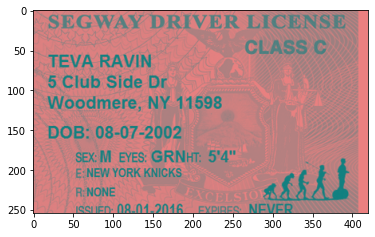

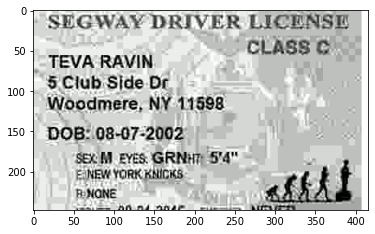

In [ ]:
%pylab inline
import scipy.misc
import cv2
img1 = cv2.imread('/content/driv2.pgm')
img = img1[220:474, 180:600]
w=8 #modify it if you want, maximal 8 due to default quantization table is 8*8
w=max(2,min(8,w))
h=w
xLen = img.shape[1]//w
yLen = img.shape[0]//h
runBits=1 #modify it if you want
bitBits=3  #modify it if you want
rbBits=runBits+bitBits ##(run,bitSize of coefficient)
useYCbCr=True #modify it if you want
useHuffman=True #modify it if you want
quantizationRatio=1 #modify it if you want, quantization table=default quantization table * quantizationRatio

from skimage.color import rgb2ycbcr,ycbcr2rgb
def myYcbcr2rgb(ycbcr):
  return (ycbcr2rgb(ycbcr).clip(0,1)*255).astype(uint8)
originalImg=copy(img)
ycbcr=rgb2ycbcr(img)
rgb=myYcbcr2rgb(ycbcr)
imshow(ycbcr.astype(uint8))
figure()
imshow(rgb)
if (useYCbCr):
  img=ycbcr
allclose(rgb,originalImg,atol=1)

def toBlocks(img):
  blocks = zeros((yLen,xLen,h,w,3),dtype=int16)
  for y in range(yLen):
    for x in range(xLen):
      blocks[y][x]=img[y*h:(y+1)*h,x*w:(x+1)*w]
  return array(blocks)
blocks = toBlocks(img)

from scipy.fftpack import dct,idct
def dctOrDedctAllBlocks(blocks,type="dct"):
  f=dct if type=="dct" else idct
  dedctBlocks = zeros((yLen,xLen,h,w,3))
  for y in range(yLen):
    for x in range(xLen):
      d = zeros((h,w,3))
      for i in range(3):
        block=blocks[y][x][:,:,i]
        d[:,:,i]=f(f(block.T, norm = 'ortho').T, norm = 'ortho')
        if (type!="dct"):
          d=d.round().astype(int16)
      dedctBlocks[y][x]=d
  return dedctBlocks
dctBlocks=dctOrDedctAllBlocks(blocks,"dct")

def blocks2img(blocks):
  W=xLen*w
  H=yLen*h
  img = zeros((H,W,3))
  for y in range(yLen):
    for x in range(xLen):
      img[y*h:y*h+h,x*w:x*w+w]=blocks[y][x]
  return img
newImg=blocks2img(dctBlocks)


#quantization table
QY=array([[16,11,10,16,24,40,51,61],
     [12,12,14,19,26,58,60,55],
     [14,13,16,24,40,57,69,56],
     [14,17,22,29,51,87,80,62],
     [18,22,37,56,68,109,103,77],
     [24,35,55,64,81,104,113,92],
     [49,64,78,87,103,121,120,101],
     [72,92,95,98,112,100,103,99]])
QC=array([[17,18,24,47,99,99,99,99],
     [18,21,26,66,99,99,99,99],
     [24,26,56,99,99,99,99,99],
     [47,66,99,99,99,99,99,99],
     [99,99,99,99,99,99,99,99],
     [99,99,99,99,99,99,99,99],
     [99,99,99,99,99,99,99,99],
     [99,99,99,99,99,99,99,99]])
QY=QY[:w,:h]
QC=QC[:w,:h]
qDctBlocks=copy(dctBlocks)
Q3 = moveaxis(array([QY]+[QC]+[QC]),0,2)*quantizationRatio if useYCbCr else dstack([QY*quantizationRatio]*3)#all r-g-b/Y-Cb-Cr 3 channels need to be quantized
Q3=Q3*((11-w)/3)
qDctBlocks=(qDctBlocks/Q3).round().astype('int16') 

qDctImg=blocks2img(qDctBlocks).astype('int16')
Qrandom=arange(200,200+w*h).reshape(w,h)
qRandDctBlocks=copy(dctBlocks)
Qr3 = dstack([Qrandom]*3)
qRandDctBlocks/=Qr3
qRandDctBlocks=qRandDctBlocks.round().astype('int16')
dedctBlocks=dctOrDedctAllBlocks(dctBlocks,"idct")
dedctBlocks=dctOrDedctAllBlocks(qDctBlocks*Q3,"idct")
dedctBlocks=dctOrDedctAllBlocks(qRandDctBlocks*Qr3,"idct")


def zigZag(block):
  lines=[[] for i in range(h+w-1)] 
  for y in range(h): 
    for x in range(w): 
      i=y+x 
      if(i%2 ==0): 
          lines[i].insert(0,block[y][x]) 
      else:  
          lines[i].append(block[y][x]) 
  return array([coefficient for line in lines for coefficient in line])
zigZag(qDctBlocks[0][0][:,:,0])


!pip install huffman
import huffman
from collections import Counter
def huffmanCounter(zigZagArr):
  rbCount=[]
  run=0
  for AC in zigZagArr[1:]:
    if(AC!=0):
      AC=max(AC,1-2**(2**bitBits-1)) if AC<0 else min(AC,2**(2**bitBits-1)-1)
      if(run>2**runBits-1):
        runGap=2**runBits
        k=run//runGap
        for i in range(k):
          rbCount.append('1'*runBits+'0'*bitBits)
        run-=k*runGap
      run=min(run,2**runBits-1) 
      bitSize=min(int(ceil(log(abs(AC)+0.000000001)/log(2))),2**bitBits-1)
      rbCount.append(format(run<<bitBits|bitSize,'0'+str(rbBits)+'b'))
      run=0
    else:
      run+=1
  rbCount.append("0"*(rbBits))
  return Counter(rbCount)
rbCount=zeros(3,dtype=Counter)
rbCount[0]=huffmanCounter(zigZag(qDctBlocks[0][0][:,:,0]))
rbCount[1]=huffmanCounter(zigZag(qDctBlocks[0][0][:,:,1]))
rbCount[2]=huffmanCounter(zigZag(qDctBlocks[0][0][:,:,2]))
rbCount=sum(rbCount)


def runLengthReadable(zigZagArr,lastDC):
  rlc=[]
  run=0
  newDC=min(zigZagArr[0],2**(2**bitBits-1)-1)
  DC=newDC-lastDC
  bitSize=max(0,min(int(ceil(log(abs(DC)+0.000000001)/log(2))),2**bitBits-1))
  rlc.append([array(bitSize),DC])
  code=format(bitSize, '0'+str(bitBits)+'b')+"\n"
  if (bitSize>0):
    code=code[:-1]+","+(format(DC,"b") if DC>0 else ''.join([str((int(b)^1)) for b in format(abs(DC),"b")]))+"\n"
  for AC in zigZagArr[1:]:
    if(AC!=0):
      AC=max(AC,1-2**(2**bitBits-1)) if AC<0 else min(AC,2**(2**bitBits-1)-1)
      if(run>2**runBits-1):
        runGap=2**runBits
        k=run//runGap
        for i in range(k):
          code+='1'*runBits+'0'*bitBits+'\n'
          rlc.append([runGap-1,0])
        run-=k*runGap
      bitSize=min(int(ceil(log(abs(AC)+0.000000001)/log(2))),2**bitBits-1)
      #VLI encoding (next 2 lines of codes)
      code+=format(run<<bitBits|bitSize,'0'+str(rbBits)+'b')+','
      code+=(format(AC,"b") if AC>=0 else ''.join([str((int(b)^1)) for b in format(abs(AC),"b")]))+"\n"
      rs=zeros(1,dtype=object)
      rs[0]=array([run,bitSize])
      rs= append(rs,AC)
      rlc.append(rs)
      run=0
    else:
      run+=1
  rlc.append([0,0])
  code+="0"*(rbBits)#end
  return array(rlc),code,newDC
b=zeros(64,dtype=int16)
b[0]=222
b[4]=9
b[11]=33
b[12]=25
b[14]=-129
b[17]=77
b[27]=12
b[47]=82
print(b)
arr,code,DC=runLengthReadable(b,0)


def runLength(zigZagArr,lastDC,hfm=None):
  rlc=[]
  run=0
  newDC=min(zigZagArr[0],2**(2**bitBits-1))
  DC=newDC-lastDC
  bitSize=max(0,min(int(ceil(log(abs(DC)+0.000000001)/log(2))),2**bitBits-1))
  code=format(bitSize, '0'+str(bitBits)+'b')
  if (bitSize>0):
   code+=(format(DC,"b") if DC>0 else ''.join([str((int(b)^1)) for b in format(abs(DC),"b")]))
  for AC in zigZagArr[1:]:
    if(AC!=0):
      AC=max(AC,1-2**(2**bitBits-1)) if AC<0 else min(AC,2**(2**bitBits-1)-1)
      if(run>2**runBits-1):
        runGap=2**runBits
        k=run//runGap
        for i in range(k):
          code+=('1'*runBits+'0'*bitBits)if hfm == None else  hfm['1'*runBits+'0'*bitBits]#end
        run-=k*runGap
      run=min(run,2**runBits-1) 
      bitSize=min(int(ceil(log(abs(AC)+0.000000001)/log(2))),2**bitBits-1)
      rb=format(run<<bitBits|bitSize,'0'+str(rbBits)+'b') if hfm == None else hfm[format(run<<bitBits|bitSize,'0'+str(rbBits)+'b')]
      code+=rb+(format(AC,"b") if AC>=0 else ''.join([str((int(b)^1)) for b in format(abs(AC),"b")]))
      run=0
    else:
      run+=1
  code+="0"*(rbBits) if hfm == None else  hfm["0"*(rbBits)]#end
  return code,newDC
code1,DC=runLength(zigZag(qDctBlocks[0][0][:,:,0]),0)
code2,DC=runLength(zigZag(qDctBlocks[0][0][:,:,1]),DC)
code3,DC=runLength(zigZag(qDctBlocks[0][0][:,:,2]),DC)
codeBlock=code1+code2+code3

def runLength2bytes(code):
  return bytes([len(code)%8]+[int(code[i:i+8],2) for i in range(0, len(code), 8)])

def huffmanCounterWholeImg(blocks):
  rbCount=zeros(xLen*yLen*3,dtype=Counter)
  zz=zeros(xLen*yLen*3,dtype=object)
  for y in range(yLen):
    for x in range(xLen):
      for i in range(3):
        zz[y*xLen*3+x*3+i]=zigZag(blocks[y, x,:,:,i])
        rbCount[y*xLen*3+x*3+i]=huffmanCounter(zz[y*xLen*3+x*3+i])
  return sum(rbCount),zz
rbCount,zz=huffmanCounterWholeImg(qDctBlocks)
hfm=huffman.codebook(rbCount.items())
sortedHfm=[[hfm[i[0]],i[0],rbCount[i[0]]] for i in rbCount.most_common()]

def savingQuantizedDctBlocks(blocks):
  rbCount,zigZag=huffmanCounterWholeImg(blocks)
  hfm=huffman.codebook(rbCount.items())
  sortedHfm=[[hfm[i[0]],i[0]] for i in rbCount.most_common()]
  code=""
  DC=0
  for y in range(yLen):
    for x in range(xLen):
      for i in range(3):
        codeNew,DC=runLength(zigZag[y*xLen*3+x*3+i],DC,hfm if useHuffman else None)
        code+=codeNew
  savedImg=runLength2bytes(code)
  print(str(code[:100])+"......")
  print(str(savedImg[:20])+"......")
  print("Image original size:    %.3f MB"%(img.size/(2**20)))
  print("Compression image size: %.3f MB"%(len(savedImg)/2**20))
  print("Compression ratio:      %.2f : 1"%(img.size/2**20/(len(savedImg)/2**20)))
  c1 = (img.size/2**20/(len(savedImg)/2**20))
  return bytes([int(format(xLen,'012b')[:8],2),int(format(xLen,'012b')[8:]+format(yLen,'012b')[:4],2),int(format(yLen,'012b')[4:],2)])+savedImg,sortedHfm,c1
import time
t1=time.time()
savedImg,sortedHfmForDecode,C5=savingQuantizedDctBlocks(qDctBlocks)
t2=time.time()
save = open("img.bin", "wb")
save.write(savedImg)
save.close()


qr=10
qDctBlocks5=copy(dctBlocks)
Q3_5 = Q3*qr
qDctBlocks5=(qDctBlocks5/Q3_5).round().astype('int16')
dedctBlocks=dctOrDedctAllBlocks(dctBlocks,"idct")
dedctBlocks=dctOrDedctAllBlocks(qDctBlocks5*Q3_5,"idct")
savedImg1,rbCount1,C5_1=savingQuantizedDctBlocks(qDctBlocks5)
save = open("img5foldCompression.bin", "wb")
save.write(savedImg1)
save.close()

def bytes2runLength(bytes):
  return "".join([format(i,'08b') for i in list(bytes)][1:-1 if list(bytes)[-1]!=0 else None])+(format(list(bytes)[-1],'0'+str(list(bytes)[0])+'b')if list(bytes)[-1]!=0 else"")

gaps=[i for i in range(1,8)]+[8-i for i in range(8)]+[-1]
locations=[[int(sum(range(gaps[i-1]+1))),sum(range(gaps[i]+1))] if gaps[i]>gaps[i-1]  else [64-sum(range(gaps[i-1])),64-sum(range(gaps[i]))] for i in range(len(gaps)-1)]
def deZigZag(zigZagArr):
  zigZagArr=[zigZagArr[l[0]:l[1]] for l in locations]
  block=zeros((h,w),dtype=int16)
  for y in range(h): 
    for x in range(w): 
      i=y+x 
      if(i%2 != 0): 
        block[y][x]=zigZagArr[i][0]
        zigZagArr[i]=zigZagArr[i][1:]
      else: 
        block[y][x]=zigZagArr[i][-1:][0]
        zigZagArr[i]=zigZagArr[i][:-1]
  return block


  #explaination of above section of codes
z=zigZag(qDctBlocks[0][0][:,:,0])
gaps=[ i for i in range(1,w)]+[w-i for i in range(w)]+[-1]
locations=[[int(sum(range(gaps[i-1]+1))),sum(range(gaps[i]+1))] if gaps[i]>gaps[i-1]  else [w*h-sum(range(gaps[i-1])),w*h-sum(range(gaps[i]))] for i in range(len(gaps)-1)]
zz1=[z[l[0]:l[1]] for l in locations]
for i in range(len(zz1)): 
  print(zz1[i])


if(w%2==0):
  x=concatenate([append(arange(0,i),arange(0,i)[::-1][1:]) for i in range(2,w+1,2)])
  x=append(x,(w-1-x[::-1])[w:])
  y=concatenate([append(arange(0,i),arange(0,i)[::-1][1:]) for i in range(1,w+1,2)])
  y=append(append(y,arange(0,h)),(h-1-y[::-1]))
else:
  x=concatenate([append(arange(0,i),arange(0,i)[::-1][1:]) for i in range(2,w,2)])
  x=append(append(x,arange(0,w)),w-1-x[::-1])
  y=concatenate([append(arange(0,i),arange(0,i)[::-1][1:]) for i in range(1,w+2,2)])
  y=append(y[:-w],w-1-y[::-1])
zzLine=dstack([x]+[y])[0]
zzMatrix=zeros((w,h),dtype=int8)
for i in range(len(zzLine)):
  zzMatrix[zzLine[i][1]][zzLine[i][0]]=i


def deZigZag2(zigZagArr):
  block=zeros((h,w),dtype=int16)
  for i in range(len(zzLine)):
    block[zzLine[i][1],zzLine[i][0]]=zigZagArr[i]
  return block
deZigZag2(zigZag(qDctBlocks[0][0][:,:,0]))


load = open("img.bin", "rb")
loadedbytes = load.read()
code=bytes2runLength(loadedbytes[2:])

def loadingQuantizedDctBlocks(loadedbytes,sortedHfm=None):
  runMax=2**runBits-1
  xLen=int(format(loadedbytes[0],'b')+format(loadedbytes[1],'08b')[:4],2)
  yLen=int(format(loadedbytes[1],'08b')[4:]+format(loadedbytes[2],'08b'),2)
  code=bytes2runLength(loadedbytes[3:])
  blocks = zeros((yLen,xLen,h,w,3),dtype=int16)
  lastDC=0
  rbBitsTmp=rbBits
  rbTmp=""
  cursor=0 #don't use code=code[index:] to remove readed strings when len(String) is large like 1,000,000. It will be extremely slow
  for y in range(yLen):
    for x in range(xLen):
      for i in range(3):
        zz=zeros(64)
        bitSize=int(code[cursor:cursor+bitBits],2)
        DC=code[cursor+bitBits:cursor+bitBits+bitSize]
        DC=(int(DC,2) if DC[0]=="1" else -int(''.join([str((int(b)^1)) for b in DC]),2)) if bitSize>0 else 0
        cursor+=(bitBits+bitSize)
        zz[0]=DC+lastDC
        lastDC=zz[0]
        r=1
        while(True):
          if(sortedHfm!=None):
            for ii in sortedHfm:
              if (ii[0]==code[cursor:cursor+len(ii[0])]):
                rbTmp=ii[1]
                rbBitsTmp=len(ii[0])
                break
            run=int(rbTmp[:runBits],2)
            bitSize=int(rbTmp[runBits:],2)
          else:
            run=int(code[cursor:cursor+runBits],2)
            bitSize=int(code[cursor+runBits:cursor+rbBitsTmp],2)
          if (bitSize==0):
            cursor+=rbBitsTmp
            if(run==runMax):
              r+=(run+1)
              continue
            else:
              break
          coefficient=code[cursor+rbBitsTmp:cursor+rbBitsTmp+bitSize]
          if(coefficient[0]=="0"):
            coefficient=-int(''.join([str((int(b)^1)) for b in coefficient]),2)
          else:
            coefficient=int(coefficient,2)
          zz[r+run]=coefficient
          r+=(run+1)
          cursor+=rbBitsTmp+bitSize    
        blocks[y,x,...,i]=deZigZag2(zz)
  return blocks
t1=time.time()
loadedBlocks=loadingQuantizedDctBlocks(loadedbytes,sortedHfmForDecode if useHuffman else None)
t2=time.time()

incorrect=qDctBlocks.size-count_nonzero((qDctBlocks==loadedBlocks)==True)
loadedDctImg=blocks2img(loadedBlocks)
deDctLoadedBlocks=dctOrDedctAllBlocks(loadedBlocks*Q3,"idct")
loadedImg=blocks2img(deDctLoadedBlocks)

#explaination of above section of codes
z1=zigZag(qDctBlocks5[0][0][:,:,0])
gaps1=[ i for i in range(1,w)]+[w-i for i in range(w)]+[-1]
locations1=[[int(sum(range(gaps1[i-1]+1))),sum(range(gaps1[i]+1))] if gaps1[i]>gaps1[i-1]  else [w*h-sum(range(gaps1[i-1])),w*h-sum(range(gaps1[i]))] for i in range(len(gaps1)-1)]
zz1_1=[z1[l[0]:l[1]] for l in locations1]
for i in range(len(zz1_1)): 
  print(zz1_1[i])

load1 = open("img5foldCompression.bin", "rb")
loadedbytes1 = load1.read()
code1=bytes2runLength(loadedbytes1[2:])

t1_1=time.time()
loadedBlocks1=loadingQuantizedDctBlocks(loadedbytes1,rbCount1 if useHuffman else None)
t2_1=time.time()


incorrect_1=qDctBlocks5.size-count_nonzero((qDctBlocks5==loadedBlocks1)==True)
loadedDctImg1=blocks2img(loadedBlocks1)
deDctLoadedBlocks1=dctOrDedctAllBlocks(loadedBlocks1*Q3_5,"idct")
loadedImg1=blocks2img(deDctLoadedBlocks1)
img5 = (myYcbcr2rgb(loadedImg1) if useYCbCr else blocks2img(dedctBlocks).astype(int16))
imshow(img5)



In [ ]:
A5 = img5.shape[0]*img5.shape[1]
print("area of text part4:",A5)
print("Compression ratio for A5:  %.2f : 1"%(C5_1))

area of text part4: 103168
Compression ratio for A5:  52.66 : 1


In [ ]:
print(img6.shape, img2.shape, img3.shape, img4.shape, img5.shape)

(248, 160, 3) (216, 600, 3) (120, 600, 3) (248, 16, 3) (248, 416, 3)


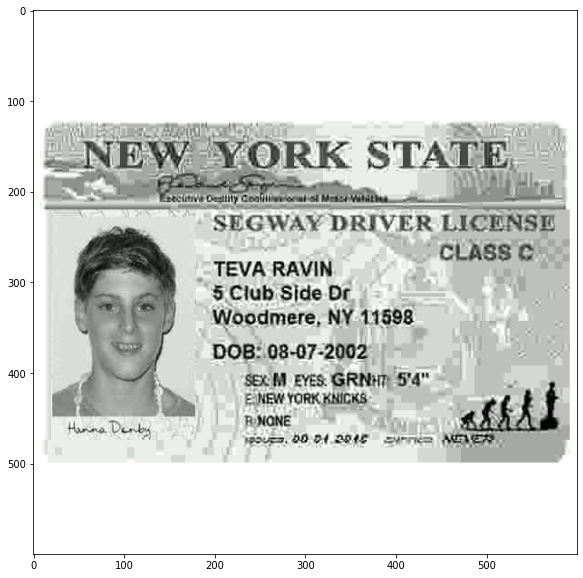

In [ ]:
import cv2
import numpy as np

img6_6 = cv2.resize(img6, (160, 254))
img5_5 = cv2.resize(img5, (420, 254))
img4_4 = cv2.resize(img4, (20, 254))
img2_2 = cv2.resize(img2, (600, 220))
img3_3 = cv2.resize(img3, (600, 126))

hor = np.hstack((img4_4, img6_6, img5_5))
ver = np.vstack((img2_2, hor, img3_3))
figure(figsize=(10,10))
imshow(ver)



In [ ]:
img = cv2.imread('/content/lena.pgm')
mse = np.mean((img - img6)**2)
max_pixel = 255.0
psnr = 20 * log10(max_pixel / sqrt(mse))
psnr

34.733052617408234

In [ ]:
import skimage.io
skimage.io.imsave('lena2.jpg', img6)

In [ ]:
import PIL
from PIL import Image
img_path = "/content/driv3.png"
img3 = Image.open(img_path)
mywidth = int(img3.size[1])
myheight = int(img3.size[0])

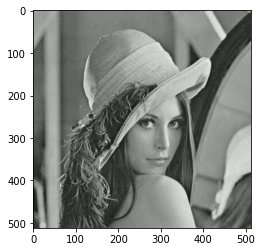

In [ ]:
img4 = img3.resize((myheight,mywidth),PIL.Image.ANTIALIAS)
img4.save('resize.jpg')
resize_path = "/content/resize.jpg"
img5 = Image.open(resize_path)
imshow(img4)

In [ ]:
img = cv2.imread('/content/lena.pgm')
mse = np.mean((img - img4)**2)
max_pixel = 255.0
psnr = 20 * log10(max_pixel / sqrt(mse))
psnr

34.733052617408234

In [ ]:
final_compression = (A1*C1_1 + A2*C2_1 + A3*C3_1 + A4*C4_1 + A5*C5_1)/(A1 + A2 + A3 + A4 + A5)
print("final compression ratio is",final_compression)

final compression ratio is 63.81418484236135
